<h1><center>Text Classification</center></h1>

In [7]:
%matplotlib inline

import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import stanza
from preprocess import * 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import explained_variance_score

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.utils import np_utils

import textblob
import seaborn as sns
import xgboost as xgb

#from keras import layers, models, optimizers

import string
import fasttext
import fasttext.util
from tqdm import tqdm
# ---- Call tqdm to see progress bar with pandas
tqdm().pandas()

0it [00:00, ?it/s]


---

<center><h2>Parameters</h2></center>

---

In [8]:
gradient_boosting   = True
xgboost_classifier  = True
shallow_network     = True
deep_learning       = True
transformers_models = True
pre_trained         = True

---

<center><i><h1>Sand Box to Load Data</h1></i></center>

---

In [114]:
FILES_PATH = "annulations/*/*/*"

In [115]:
list_docs = glob.glob(FILES_PATH)

In [116]:
# ---- label for multi-class
labels = pd.read_csv("geed_not_annul.csv", sep=";")
labels.rename(columns={"VAAT_VAL":"label"}, inplace=True)
labels_ = pd.read_csv("GeedAnnulAuto.csv", sep=";")


In [117]:
labels_.DOEL_EXTNSN_ORIG = labels_.DOEL_EXTNSN_ORIG.str.lower()

In [118]:
labels_.DOEL_EXTNSN_ORIG[labels_.DOEL_EXTNSN_ORIG=="txt"].shape[0]

2681

In [119]:
list_docs[-4:]

['annulations/not_annulations/42364364/42364364_48739439.txt',
 'annulations/not_annulations/42364373/42364373_48739444.txt',
 'annulations/not_annulations/42364376/42364376_48739446.txt',
 'annulations/not_annulations/42364445/42364445_48739492.txt']

In [120]:
labeled = []
text = []
count_utf8 = 0
count_iso = 0 
count_avoid = 0
ext_no_txt = 0
list_empty_file = []
annexe_docs = False
ref_doc = []
for i in tqdm(list_docs):
    ref = int(i.split("/")[3].split(".")[0].split("_")[1])
    
    # take into account documents annexes 
    if annexe_docs:
        if "not_" in i:
            extension = labels[labels.DOEL_EMPLC_VIRTUEL==ref].DOEL_EXTNSN_ORIG.values[0]
            if extension != "txt":
                ext_no_txt += 1
                continue
        else:
            extension = labels_[labels_.DOEL_EMPLC_VIRTUEL==ref].DOEL_EXTNSN_ORIG.values[0]
            if extension != "txt":
                ext_no_txt += 1
                continue
    try:
        with open(i,'r', encoding="utf-8") as doc:
            text_ = doc.read()
            
            if text_ == '':
                count_avoid += 1 
                list_empty_file.append(i)
                continue
            if len(text_.split()) > 3000:
                count_avoid += 1
                continue
            text.append(text_)
            
            if "not_" in i:
                labeled.append(labels[labels.DOEL_EMPLC_VIRTUEL==ref].label.values[0])
            else:
                labeled.append("annulation")
            ref_doc.append(ref)
        count_utf8 += 1 
    except:
        with open(i,'r', encoding="ISO-8859-1") as doc:
            text_ = doc.read()
            
            if text_ == '':
                count_avoid += 1 
                list_empty_file.append(i)
                continue
            if len(text_.split()) > 3000:
                count_avoid += 1 
                continue
            text.append(text_)
            
            if "not_" in i:
                labeled.append(labels[labels.DOEL_EMPLC_VIRTUEL==ref].label.values[0])
            else:
                labeled.append("annulation")
            ref_doc.append(ref)
        count_iso += 1 
    

100%|██████████| 22904/22904 [00:25<00:00, 908.89it/s]


In [121]:
print(f"The number of rows is {len(text)}")

The number of rows is 20977


In [122]:
print(f"Number of mail without txt extension : {ext_no_txt}")

Number of mail without txt extension : 0


In [123]:
print(f"Number of avoid mail : {count_avoid}")

Number of avoid mail : 1927


In [124]:
print(f"Proportion of files in utf8: {round(100*count_utf8/(count_utf8+count_iso),2)}% ; Proportion of files in ISO-5589-1: {round(100*count_iso/(count_utf8+count_iso),2)}%")

Proportion of files in utf8: 54.25% ; Proportion of files in ISO-5589-1: 45.75%


In [126]:
df = pd.DataFrame(data=np.transpose([text, ref_doc, labeled]), columns=["mails","ref_doc", "label"])

In [127]:
df = df.sample(frac=1).reset_index(drop=True)

In [128]:
n_labels = set(df.label.unique())

In [129]:
print(f"The number of labels is {len(n_labels)}")

The number of labels is 39


In [130]:
# ---- Create 2 classes
#df.label[df.label!="annulation"] = "other"

# ---- Create 4 classes
df.label[(df.label!="co") & (df.label!="ft") & (df.label!="annulation")] = "other"
#df.label[(df.label!="annulation") & (df.label!="poubelle")] = "non_annulation"

In [131]:
df.label.value_counts()

annulation    9432
other         6197
co            3209
ft            2139
Name: label, dtype: int64

---

<center><i><h1>Sart Pipeline</h1></i></center>

---

<h1>Preprocessing </h1>

---

The text corpora and other textual data in their native raw formats are normally not
well formatted and standardized and of course we should expect this, after all, text data
is highly unstructured! Text processing or, to be more specific preprocessing, involves a
wide variety of techniques that convert raw text into well-defined sequences of linguistic
components that have standard structure and notation. Additional metadata is often
also present in the form of annotations to give more meaning to the text components like
tags. The following list gives us an idea of some of the most popular text preprocessing
and understanding techniques.

Steps : 
- Removing HTML tags
- Tokenization
- Removing unnecessary tokens and stopwords
- Handling contractions
- Correcting spelling errors
- Stemming
- Lemmatization
- Tagging
- Chunking
- Parsing

> [Chapter 3 processing and understanding Text p.116 - Text Analytics with Python, Dipanjan Sarkar, 2019](https://www.apress.com/gp/book/9781484243534)

Tomas Mikolov is one of the developers of word2vec, a popular word embedding method. He suggests only very minimal text cleaning is required when learning a word embedding model.
Below is his response when pressed with the question about how to best prepare text data for word2vec.

><i>There is no universal answer. It all depends on what you plan to use the vectors for. In my experience, it is usually good to disconnect (or remove) punctuation from words, and sometimes also convert all characters to lowercase. One can also replace all numbers (possibly greater than some constant) with some single token such as .
>
>All these pre-processing steps aim to reduce the vocabulary size without removing any important content (which in some cases may not be true when you lowercase certain words, ie. ‘Bush’ is different than ‘bush’, while ‘Another’ has usually the same sense as ‘another’). The smaller the vocabulary is, the lower is the memory complexity, and the more robustly are the parameters for the words estimated. You also have to pre-process the test data in the same way.</i>
>
>…
>
><i>In short, you will understand all this much better if you will run experiments.</i>

> [How to Clean Text for Machine Learning with Python, Jason Brownlee](https://machinelearningmastery.com/clean-text-machine-learning-python/)

---

In [132]:
df.mails = df.mails.str.replace("\n", " ")

In [133]:
def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

In [134]:
def func_remove_char_specific(text):
    table = '!"#$%&()*+,./:;<=>?@[\]^_`{|}~•'
    table = str.maketrans('', '', table)
    words = text.split()
    stripped = [w.translate(table) for w in words]
    return ' '.join(stripped)

In [135]:
def func_remove_upper_case(text):
    words = text.split()
    stripped = [w.lower() if w.isupper() else w for w in words]
    return " ".join(stripped)

In [136]:
df.mails = df.mails.apply(remove_whitespace)

In [137]:
df.mails = df.mails.apply(func_remove_char_specific)
df.mails = df.mails.apply(func_remove_upper_case)

In [138]:
df.label.value_counts()

annulation    9432
other         6197
co            3209
ft            2139
Name: label, dtype: int64

In [139]:
df['char_count'] = df['mails'].apply(len)
df['word_count'] = df['mails'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['mails'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] = df['mails'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
df['upper_case_word_count'] = df['mails'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

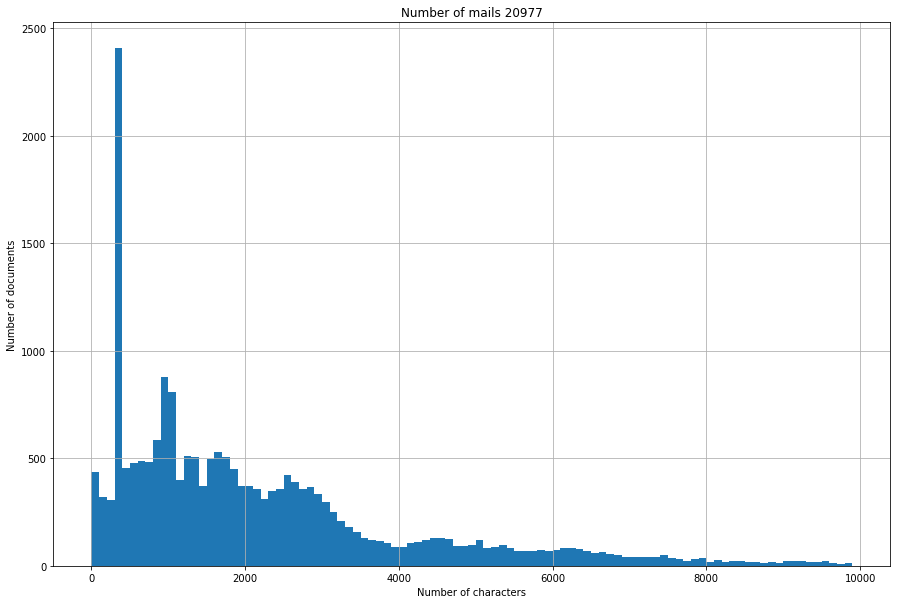

In [140]:
plt.figure(figsize=(15,10))
plt.hist(df.char_count.values, bins = range(0, 10000, 100))
plt.title(f"Number of mails {df.shape[0]}")
plt.xlabel("Number of characters")
plt.ylabel("Number of documents")
plt.grid(True)
plt.show()

<h1>Machine Learning</h1>

---

In [166]:
def func_roc_auc_curve(model, valid_seq_x, valid_y, label=labels, gb=gradient_boosting):
    # generate a no skill prediction (majority class)
    
    ns_probs = [0 for _ in range(len(valid_y.reshape(-1, 1)))]
    # predict probabilities
    if gb:
        lr_probs = model.predict_proba(valid_seq_x)
    else:    
        lr_probs = model.predict(valid_seq_x)
    #dummy_ns = np.zeros(valid_y.shape[0]*nb_label).reshape(valid_y.shape[0], nb_label)
    # keep probabilities for the positive outcome only
    #lr_probs = lr_probs[:, 1]
    # calculate scores
    #print(valid_y.shape, lr_probs.shape)
    #print(valid_y.shape, dummy_ns.shape)
    
    
    #lr_auc = roc_auc_score(valid_y, lr_probs, average="weighted", multi_class="ovr" )
    #print(lr_auc)
    
    plt.figure(figsize=(10,8))
    if len(label)==2:
        #ns_auc = roc_auc_score(valid_y, ns_probs, average="weighted")
        lr_auc = roc_auc_score(valid_y, lr_probs[:,1], average="weighted")
        ns_fpr, ns_tpr, _ = roc_curve(valid_y, ns_probs)
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        
        lr_fpr, lr_tpr, _ = roc_curve(valid_y, lr_probs[:,1])
            # plot the roc curve for the model

        plt.plot(lr_fpr, lr_tpr, label=f'Class (area {round(lr_auc,3)})')
            # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
            # show the grid
        plt.grid(True)
            # show the legend
        plt.legend()
    else:
        dummy_y = np_utils.to_categorical(valid_y)
        #ns_auc = roc_auc_score(valid_y, dummy_ns, average="weighted", multi_class="ovr")
        lr_auc_multi = []
        for i in enumerate(label):
            lr_auc_multi.append(round(roc_auc_score(dummy_y[:,i[0]], lr_probs[:,i[0]], average="weighted"),3))
            print(f"ROC AUC class {i[1]}: {lr_auc_multi[-1]}")
        lr_auc = roc_auc_score(dummy_y, lr_probs, average="weighted", multi_class="ovr" )
    
        ns_fpr, ns_tpr = [i/10 for i in list(range(0, 11, 1))], [i/10 for i in list(range(0, 11, 1))] #f(range(0, 0.1, 1))
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        for i in range(lr_probs.shape[1]):
            lr_fpr, lr_tpr, _ = roc_curve(dummy_y[:,i], lr_probs[:,i])
            # plot the roc curve for the model

            plt.plot(lr_fpr, lr_tpr, label=f'Class {label[i]} (area {lr_auc_multi[i]})')
            # axis labels
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            # show the grid
            plt.grid(True)
            # show the legend
            plt.legend()
            # show the plot
    # summarize scores
    #print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('\nROC AUC=%.3f \n' % (lr_auc))
    # calculate roc curves
    #print(roc_curve(dummy_y[:,0], lr_probs[:,0]))
    
    #print(lr_probs[:,1])
    
    
    
    plt.show()
    
def func_confusion_matrix(model, valid_y, valid_seq_x,  labels=labels):
    if len(labels)==2:
        matrice = pd.DataFrame(confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(-1)), \
             columns=['Predicted Negative', "Predicted Positive"], index=['Actual Negative', 'Actual Positive'])
        print(matrice)
        return matrice
    else:
        
        dummy_y = np_utils.to_categorical(valid_y)
        mcm = multilabel_confusion_matrix(dummy_y, np_utils.to_categorical(model.predict(valid_seq_x).argmax(-1)))
        df_mcm = pd.DataFrame()
        for i in zip(mcm, labels):
            mcm = pd.DataFrame(data=i[0], columns=['Predicted Negative', "Predicted Positive"], index=['Actual Negative', 'Actual Positive'])
            df_mcm = df_mcm.append(mcm)
            print("\nConfusion matrix for classe: %s \n" %(i[1]))
            print(mcm)
            print("\n")
        return df_mcm

def func_precision_recall_curve(model, valid_seq_x, valid_y, label=labels, gb=gradient_boosting):
    # predict probabilities
    if gb:
        lr_probs = model.predict_proba(valid_seq_x)
    else:
        lr_probs = model.predict(valid_seq_x)
    
    
    print("\n")
    plt.figure(figsize=(10,8))
    
    if len(label)==2:
        
        precision, recall, thresholds = precision_recall_curve(valid_y, lr_probs[:,1])
        # calculate precision-recall AUC
        
        lr_f1 = f1_score(valid_y,lr_probs.argmax(-1))
        lr_auc = auc(recall, precision)
        # summarize scores
        print('Model: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
        plt.plot(recall, precision, marker='.', label='Nodel')
        no_skill = len(valid_y[valid_y==1]) / len(valid_y)
        plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    else:
        dummy_y = np_utils.to_categorical(valid_y)
        dummy_lr = np_utils.to_categorical(lr_probs.argmax(-1))
        for i in enumerate(label):
            precision, recall, thresholds = precision_recall_curve(dummy_y[:,i[0]], lr_probs[:,i[0]])
            # calculate precision-recall AUC
            lr_f1 = f1_score(dummy_y[:,i[0]], dummy_lr[:,i[0]]) 
            lr_auc = auc(recall, precision)
            # summarize scores
            print('Model class: %s --> f1=%.3f AUC=%.3f' % (i[1], lr_f1, lr_auc))
            plt.plot(recall, precision, label='Class %s' %(i[1]))
        no_skill = len(valid_y[valid_y>=1]) / len(valid_y)
        plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot the precision-recall curves
    print("\n")
    
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the grid
    plt.grid(True)
    # show the plot
    plt.show()
    
    
def func_plot_eval_xgb(model, label=labels):
    # retrieve performance metrics
    results = model.evals_result()
    if len(labels)>2:
        log_ = "mlogloss"
        error_= "merror"
    else:
        log_ = "logloss"
        error_= "error"
        
        
    epochs = len(results['validation_0'][error_])
    x_axis = range(0, epochs)

    plt.figure(figsize=(15,10))
    plt.subplot(221)
    # Plot training & validation accuracy values
    plt.plot(x_axis, results['validation_0'][log_], label='Train')
    plt.plot(x_axis, results['validation_1'][log_], label='Test')
    plt.ylabel('Log Loss')
    plt.xlabel('Epochs')
    plt.title('XGBoost Log Loss')
    plt.legend(loc='upper left')
    plt.grid(True)


    # Plot training & validation loss values
    plt.subplot(222)
    plt.plot(x_axis, results['validation_0'][error_], label='Train')
    plt.plot(x_axis, results['validation_1'][error_], label='Test')
    plt.legend()
    plt.ylabel('Classification Error')
    plt.xlabel('Epochs')
    plt.title('XGBoost Classification Error')
    plt.legend( loc='upper left')
    plt.grid(True)
    plt.show()

In [142]:
# split the dataset into training and validation datasets 
train_x, valid_x, y_train, y_valid = model_selection.train_test_split(df['mails'], df['label'], random_state=42, stratify=df["label"])

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(y_train)
valid_y = encoder.fit_transform(y_valid)

---

<h2>Save Unique Labels</h2>

---

In [144]:
labels = df.label.unique()
test=pd.DataFrame(data=np.transpose([labels,encoder.fit_transform(labels)]), columns=["labels", "encoding"]).sort_values(by=["encoding"])
labels=test.labels.tolist()

---

In [145]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['mails'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [146]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['mails'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)
print("word level tf-idf done")
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df['mails'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)
print("ngram level tf-idf done")
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(df['mails'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 
print("characters level tf-idf done")

word level tf-idf done
ngram level tf-idf done


/home/chris/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


characters level tf-idf done


---

<h2>Load Pre-Trained model fastText</h2>

---

In [147]:
pretrained = fasttext.FastText.load_model('fastText/cc.fr.300.bin')

---

<h2>Word Embeddings</h2>

---

In [148]:
# create a tokenizer 
token = Tokenizer()
token.fit_on_texts(df['mails'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=300)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=300)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = pretrained.get_word_vector(word) #embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 271316/271316 [00:04<00:00, 56233.20it/s]


In [149]:
df.head()

,mails,ref_doc,label,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count
0,12-11-191221pm Securite Acces 4188383316 21 2 ...,47077601,annulation,9651,1548,6.230471,162,241,0
1,29582261-004 La Capitale Gen 06647 pers demand...,48501671,ft,10354,1692,6.115771,120,230,0
2,De Julie Beshai jbeshaigmailcom Envoyé 10 mars...,48366796,co,1332,206,6.434783,5,51,0
3,pages etat Nouveau nouveau fax recu date heure...,46149661,annulation,2225,354,6.267606,31,54,0
4,31 October 2019 Objet Assurance des particulie...,46461554,annulation,751,111,6.705357,21,31,0


In [ ]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in tqdm(enumerate(topic_word)):
    topic_words = numpy.array(vocab)[numpy.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

In [150]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

---

<center><h2>Multinomial Naive Bayes</h2></center>

---

In [151]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print( "NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print( "NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print( "NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.7027645376549094
NB, WordLevel TF-IDF:  0.7010486177311726
NB, N-Gram Vectors:  0.6699714013346044
NB, CharLevel Vectors:  0.64232602478551


---

<center><h2>Logistic Regression</h2></center>

---

In [152]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print( "LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print( "LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print( "LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print( "LR, CharLevel Vectors: ", accuracy)

/home/chris/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR, Count Vectors:  0.786653956148713


/home/chris/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR, WordLevel TF-IDF:  0.7912297426120114


/home/chris/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR, N-Gram Vectors:  0.7651096282173498
LR, CharLevel Vectors:  0.765300285986654


/home/chris/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


---

<center><h2>SVM</h2></center>

---

In [153]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print( "SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  0.7721639656816015


---

<center><h2>RandomForest</h2></center>

---

<i><h3>RandomForest Count Vectors</h3></i>

In [154]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print( "RF, Count Vectors: ", accuracy)

RF, Count Vectors:  0.774833174451859


<i><h3>RandomForest TF-IDF</h3></i>

In [155]:
# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print( "RF, WordLevel TF-IDF: ", accuracy)

RF, WordLevel TF-IDF:  0.7754051477597712


---

<center><h2>Gradient Boosting</h2></center>

---

In [156]:
def func_gradientboosting(X_train, y_train, X_test, y_test):
    start = time.time()
    n_gbes = []
    score_gbes = []
    time_gbes = []
    n_estimators = 1000
    # We specify that if the scores don't improve by atleast 0.01 for the last
    # 10 stages, stop fitting additional stages
    gbes = ensemble.GradientBoostingClassifier(n_estimators=n_estimators,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0)
    gbes.fit(X_train, y_train)
    time_gbes.append(time.time() - start)
    
    pred = gbes.predict(X_test)
    
    accuracy = accuracy_score(y_test, pred)
    
    return gbes, pred, time_gbes, gbes.score(X_test, y_test), gbes.n_estimators_


Gradient Boosting with early stopping for Count Vectors

Early Stopping : 5 iterations without change
Execution time : 3671.492 s
Score : 78.86 %
Number of estimators : 425

Classification Report

              precision    recall  f1-score   support

  annulation       0.91      0.92      0.92      2358
          co       0.71      0.47      0.56       802
          ft       0.67      0.38      0.49       535
       other       0.68      0.89      0.77      1550

    accuracy                           0.79      5245
   macro avg       0.74      0.67      0.68      5245
weighted avg       0.79      0.79      0.78      5245


Confusion Matrix





Model class: annulation --> f1=0.919 AUC=0.979
Model class: co --> f1=0.564 AUC=0.667
Model class: ft --> f1=0.486 AUC=0.579
Model class: other --> f1=0.769 AUC=0.859




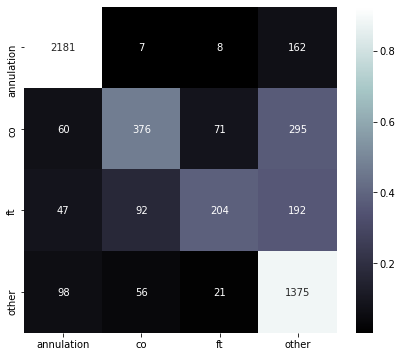

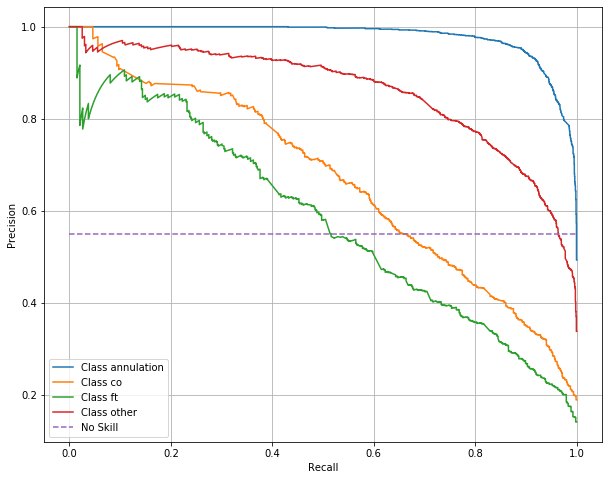



ROC AUC class annulation: 0.981
ROC AUC class co: 0.897
ROC AUC class ft: 0.905
ROC AUC class other: 0.937

ROC AUC=0.947 



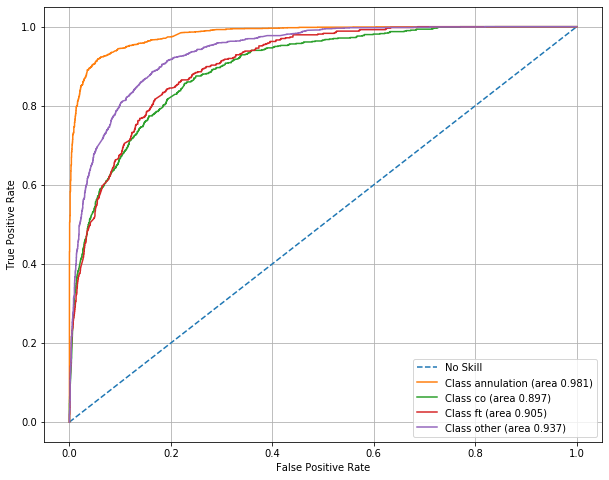



Cohen's kappa: 67.97%




In [157]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for Count Vectors\n")
    print("Early Stopping : 5 iterations without change")
    gbes, pred, time_gbes, score_gbes, n_estimators = func_gradientboosting(xtrain_count.tocsc(), train_y, xvalid_count.tocsc(), valid_y)
    print("Execution time : %.3f s" %(time_gbes[0]))
    print(f"Score : {round(100*score_gbes,2)} %" )
    print("Number of estimators : %d" %(n_estimators))
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)
    print("\n")
    func_precision_recall_curve(gbes,  xvalid_count.tocsc(), valid_y)
    print("\n")
    func_roc_auc_curve(gbes,  xvalid_count.tocsc(), valid_y, label=labels)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  pred),2)}%\n\n")


Gradient Boosting with early stopping for TF-IDF

Early Stopping : 5 iterations without change
Execution time : 1043.760 s
Score : 79.03 %
Number of estimators : 381

Classification Report

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2358
           1       0.66      0.50      0.57       802
           2       0.66      0.39      0.49       535
           3       0.69      0.86      0.77      1550

    accuracy                           0.79      5245
   macro avg       0.73      0.67      0.69      5245
weighted avg       0.79      0.79      0.78      5245


Confusion Matrix





Model class: annulation --> f1=0.927 AUC=0.981
Model class: co --> f1=0.570 AUC=0.653
Model class: ft --> f1=0.492 AUC=0.568
Model class: other --> f1=0.768 AUC=0.861




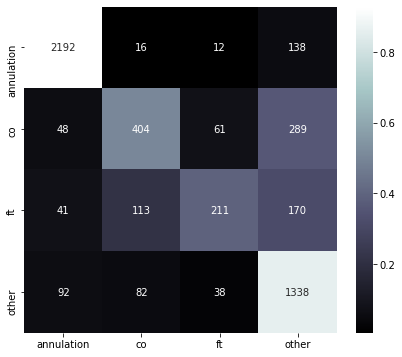

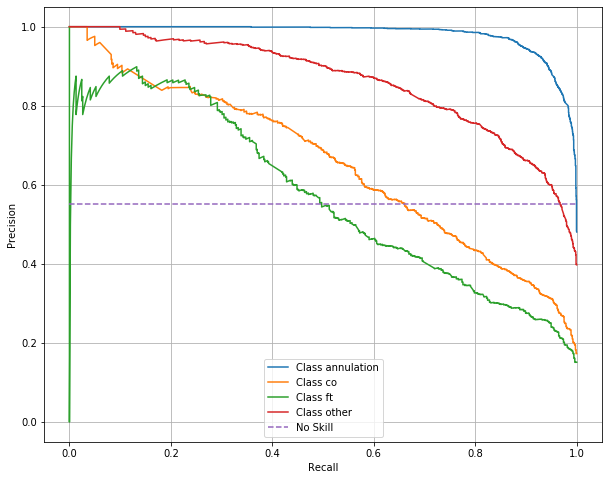



ROC AUC class annulation: 0.983
ROC AUC class co: 0.896
ROC AUC class ft: 0.904
ROC AUC class other: 0.935

ROC AUC=0.947 



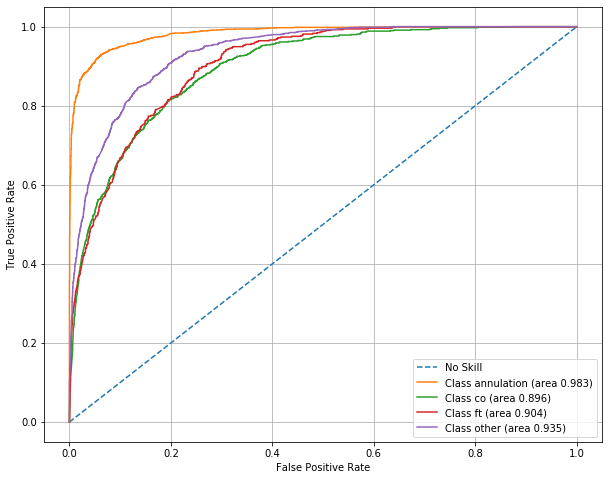



Cohen's kappa: 68.39%




In [158]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for TF-IDF\n")
    print("Early Stopping : 5 iterations without change")
    gbes, pred, time_gbes, score_gbes, n_estimators = func_gradientboosting(xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc(), valid_y)
    print("Execution time : %.3f s" %(time_gbes[0]))
    print(f"Score : {round(100*score_gbes,2)} %" )
    print("Number of estimators : %d" %(n_estimators))
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)
    print("\n")
    func_precision_recall_curve(gbes,  xvalid_tfidf.tocsc(), valid_y)
    print("\n")
    func_roc_auc_curve(gbes,  xvalid_tfidf.tocsc(), valid_y, label=labels)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  pred),2)}%\n\n")


Gradient Boosting with early stopping for TF_IDF ngram

Early Stopping : 5 iterations without change
Execution time : 1707.240 s
Score : 77.73 %
Number of estimators : 353

Classification Report

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2358
           1       0.64      0.47      0.54       802
           2       0.62      0.39      0.48       535
           3       0.68      0.85      0.76      1550

    accuracy                           0.78      5245
   macro avg       0.71      0.66      0.67      5245
weighted avg       0.77      0.78      0.77      5245


Confusion Matrix





Model class: annulation --> f1=0.916 AUC=0.977
Model class: co --> f1=0.541 AUC=0.625
Model class: ft --> f1=0.475 AUC=0.528
Model class: other --> f1=0.757 AUC=0.841




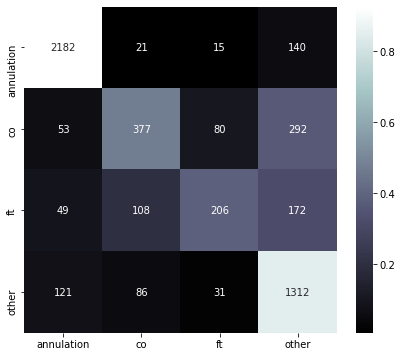

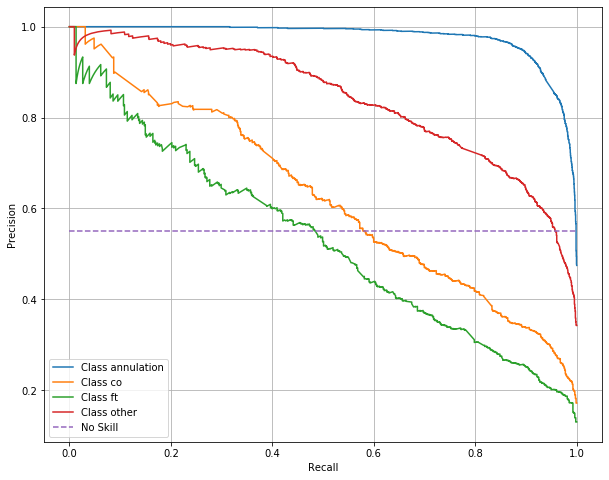



ROC AUC class annulation: 0.979
ROC AUC class co: 0.885
ROC AUC class ft: 0.889
ROC AUC class other: 0.923

ROC AUC=0.939 



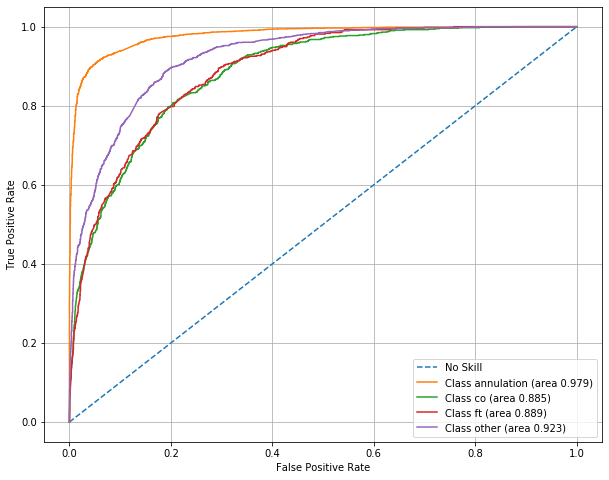



Cohen's kappa: 66.37%




In [159]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for TF_IDF ngram\n")
    print("Early Stopping : 5 iterations without change")
    gbes, pred, time_gbes, score_gbes, n_estimators = func_gradientboosting(xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y)
    print("Execution time : %.3f s" %(time_gbes[0]))
    print(f"Score : {round(100*score_gbes,2)} %" )
    print("Number of estimators : %d" %(n_estimators))
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)
    print("\n")
    func_precision_recall_curve(gbes,  xvalid_tfidf_ngram, valid_y)
    print("\n")
    func_roc_auc_curve(gbes,  xvalid_tfidf_ngram, valid_y, label=labels)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  pred),2)}%\n\n")


Gradient Boosting with early stopping for TF-IDF ngram chars

Early Stopping : 5 iterations without change
Execution time : 5756.948 s
Score : 78.65 %
Number of estimators : 288

Classification Report

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2358
           1       0.64      0.48      0.55       802
           2       0.63      0.41      0.50       535
           3       0.70      0.85      0.77      1550

    accuracy                           0.79      5245
   macro avg       0.72      0.67      0.68      5245
weighted avg       0.78      0.79      0.78      5245


Confusion Matrix





Model class: annulation --> f1=0.922 AUC=0.981
Model class: co --> f1=0.549 AUC=0.634
Model class: ft --> f1=0.498 AUC=0.567
Model class: other --> f1=0.769 AUC=0.864




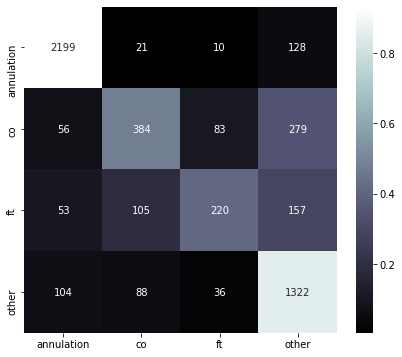

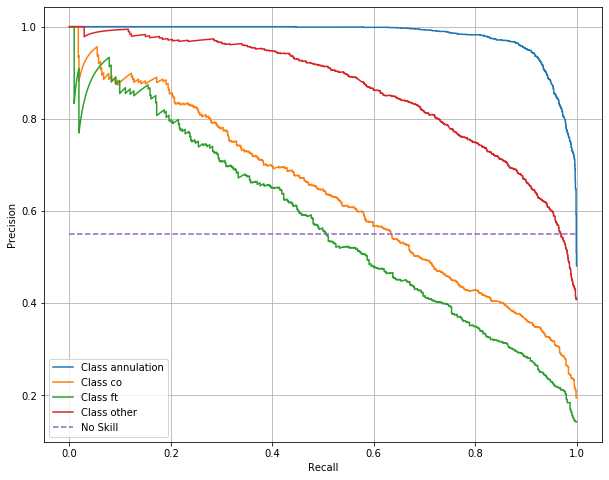



ROC AUC class annulation: 0.982
ROC AUC class co: 0.896
ROC AUC class ft: 0.905
ROC AUC class other: 0.935

ROC AUC=0.947 



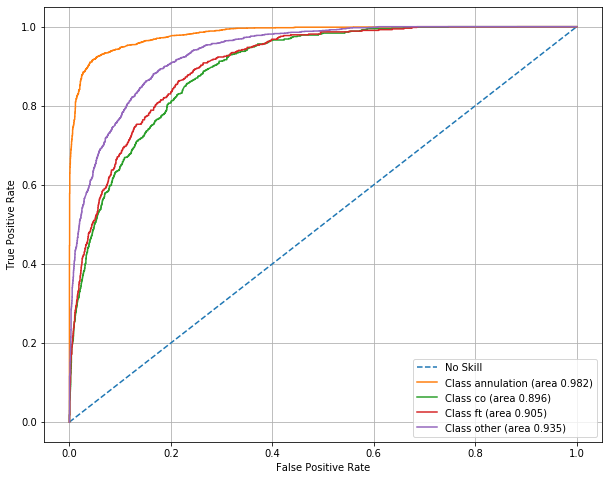



Cohen's kappa: 67.78%




In [160]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for TF-IDF ngram chars\n")
    print("Early Stopping : 5 iterations without change")
    gbes, pred, time_gbes, score_gbes, n_estimators = func_gradientboosting(xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc(), valid_y)
    print("Execution time : %.3f s" %(time_gbes[0]))
    print(f"Score : {round(100*score_gbes,2)} %" )
    print("Number of estimators : %d" %(n_estimators))
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)
    print("\n")
    func_precision_recall_curve(gbes,  xvalid_tfidf_ngram_chars.tocsc(), valid_y)
    print("\n")
    func_roc_auc_curve(gbes,  xvalid_tfidf_ngram_chars.tocsc(), valid_y, label=labels)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  pred),2)}%\n\n")


Gradient Boosting with early stopping for Word Embeddings

Early Stopping : 5 iterations without change
Execution time : 533.067 s
Score : 63.36 %
Number of estimators : 263

Classification Report

              precision    recall  f1-score   support

           0       0.70      0.83      0.76      2358
           1       0.65      0.35      0.45       802
           2       0.45      0.13      0.20       535
           3       0.55      0.66      0.60      1550

    accuracy                           0.63      5245
   macro avg       0.59      0.49      0.50      5245
weighted avg       0.62      0.63      0.61      5245


Confusion Matrix





Model class: annulation --> f1=0.756 AUC=0.847
Model class: co --> f1=0.452 AUC=0.505
Model class: ft --> f1=0.203 AUC=0.301
Model class: other --> f1=0.600 AUC=0.626




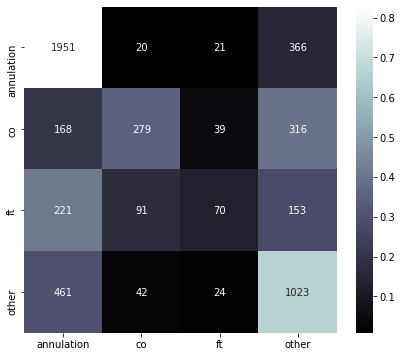

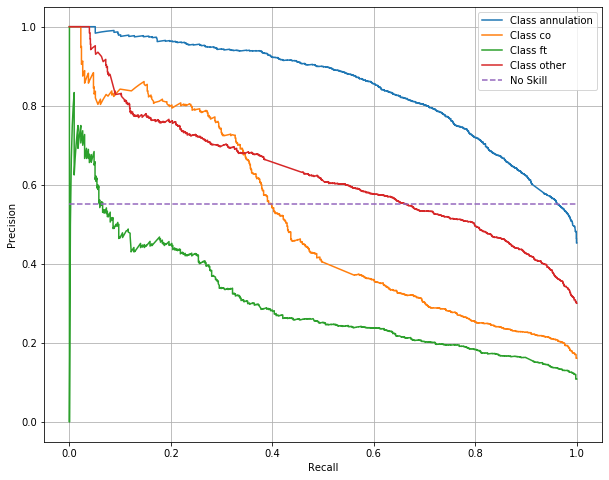



ROC AUC class annulation: 0.861
ROC AUC class co: 0.794
ROC AUC class ft: 0.775
ROC AUC class other: 0.8

ROC AUC=0.824 



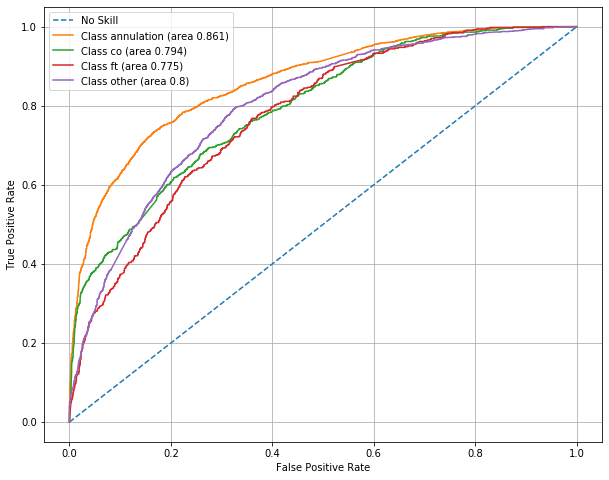



Cohen's kappa: 42.71%




In [161]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for Word Embeddings\n")
    print("Early Stopping : 5 iterations without change")
    gbes, pred, time_gbes, score_gbes, n_estimators = func_gradientboosting(train_seq_x, train_y, valid_seq_x, valid_y)
    print("Execution time : %.3f s" %(time_gbes[0]))
    print(f"Score : {round(100*score_gbes,2)} %" )
    print("Number of estimators : %d" %(n_estimators))
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)
    print("\n")
    func_precision_recall_curve(gbes,  valid_seq_x, valid_y)
    print("\n")
    func_roc_auc_curve(gbes,  valid_seq_x, valid_y, label=labels)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  pred),2)}%\n\n")

---

<h2>XGBoost Classifier</h2>

---

All the XGBoost have early stopping implemented with 10 rounds

In [162]:
def func_xgb(X_train, y_train, X_test, y_test, labels=labels):
    model = XGBClassifier(n_estimators=1000, subsample=0.8)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    if len(labels)>2:
        model.fit(X_train, y_train, eval_metric=["merror", "mlogloss"],  eval_set=eval_set,early_stopping_rounds=10, verbose=False) #
    else:
        model.fit(X_train, y_train, eval_metric=["error", "logloss"],  eval_set=eval_set,early_stopping_rounds=10, verbose=False) #
    
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(valid_y, predictions)
    print("\nAccuracy: %.2f%%" % (accuracy * 100.0))
    return model, y_pred, accuracy

def rmsle_eval(y, y0):
    
    y0=y0.get_label()    
    assert len(y) == len(y0)
    return 'error',np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))



<i><h3>XGBoost for Count Vectors</h3></i>

In [163]:
from xgboost import XGBClassifier


XGBoost for Count Vectors


Accuracy: 80.32%

Classification Report

              precision    recall  f1-score   support

  annulation       0.93      0.93      0.93      2358
          co       0.67      0.55      0.60       802
          ft       0.67      0.41      0.51       535
       other       0.72      0.87      0.79      1550

    accuracy                           0.80      5245
   macro avg       0.75      0.69      0.71      5245
weighted avg       0.80      0.80      0.80      5245


Confusion Matrix



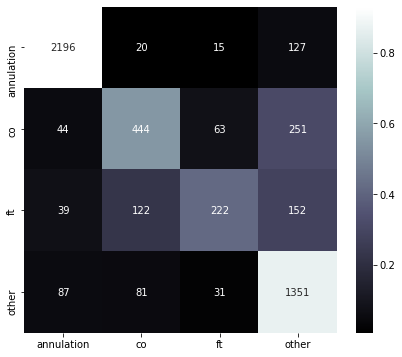

In [164]:
if xgboost_classifier:
    print("\nXGBoost for Count Vectors\n")
    xgbs, pred, accuracy = func_xgb(xtrain_count.tocsc(), train_y, xvalid_count.tocsc(), valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)



Model class: annulation --> f1=0.930 AUC=0.984
Model class: co --> f1=0.604 AUC=0.678
Model class: ft --> f1=0.513 AUC=0.608
Model class: other --> f1=0.788 AUC=0.880




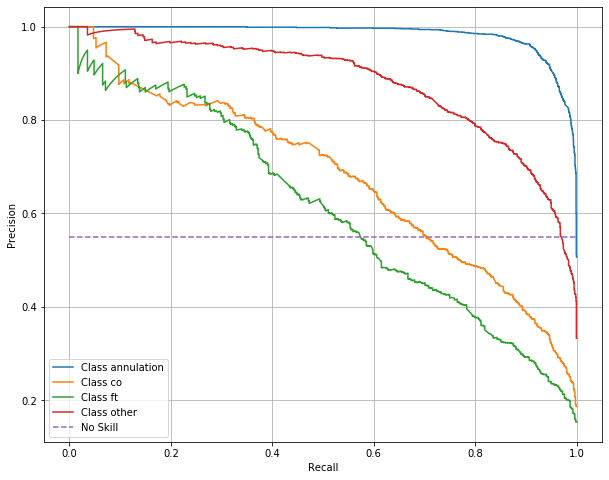



ROC AUC class annulation: 0.986
ROC AUC class co: 0.91
ROC AUC class ft: 0.914
ROC AUC class other: 0.944

ROC AUC=0.955 



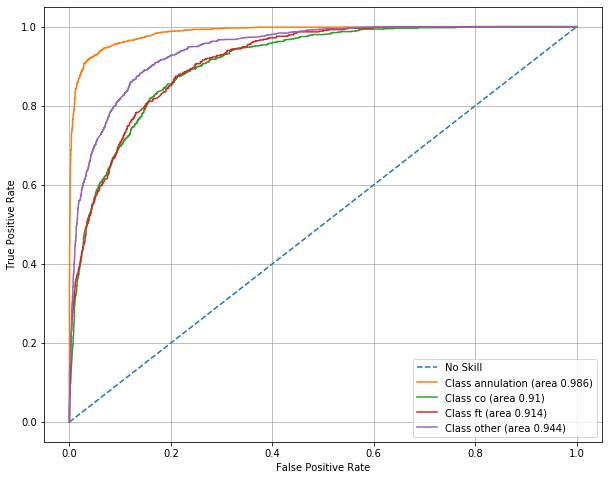


Evaluation Curves


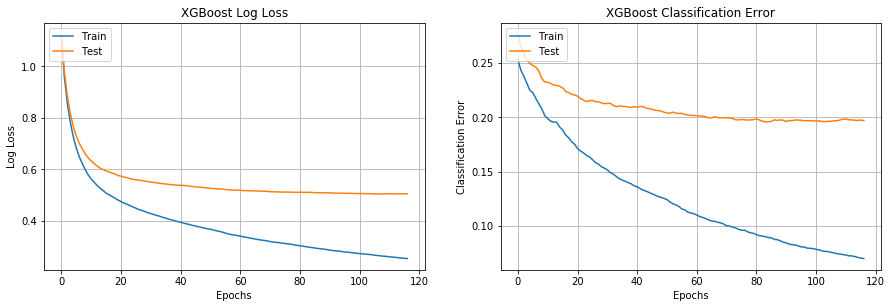



Cohen's kappa: 70.43%




In [167]:
if xgboost_classifier:
    func_precision_recall_curve(xgbs,  xvalid_count.tocsc(),  valid_y)
    print("\n")
    func_roc_auc_curve(xgbs, xvalid_count.tocsc(), valid_y)
    print("\nEvaluation Curves")
    func_plot_eval_xgb(xgbs)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_count.tocsc())),2)}%\n\n")

<i><h3>XGBoost for TF-IDF </h3></i>


XGBoost for TF_IDF


Accuracy: 80.31%

Classification Report

              precision    recall  f1-score   support

  annulation       0.93      0.93      0.93      2358
          co       0.66      0.55      0.60       802
          ft       0.69      0.45      0.54       535
       other       0.72      0.86      0.78      1550

    accuracy                           0.80      5245
   macro avg       0.75      0.70      0.71      5245
weighted avg       0.80      0.80      0.80      5245


Confusion Matrix



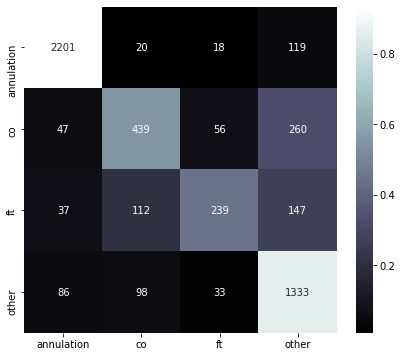

In [168]:
if xgboost_classifier:
    print("\nXGBoost for TF_IDF\n")
    xgbs, pred, accuracy = func_xgb(xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc(), valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)




Model class: annulation --> f1=0.931 AUC=0.984
Model class: co --> f1=0.597 AUC=0.660
Model class: ft --> f1=0.543 AUC=0.610
Model class: other --> f1=0.782 AUC=0.873




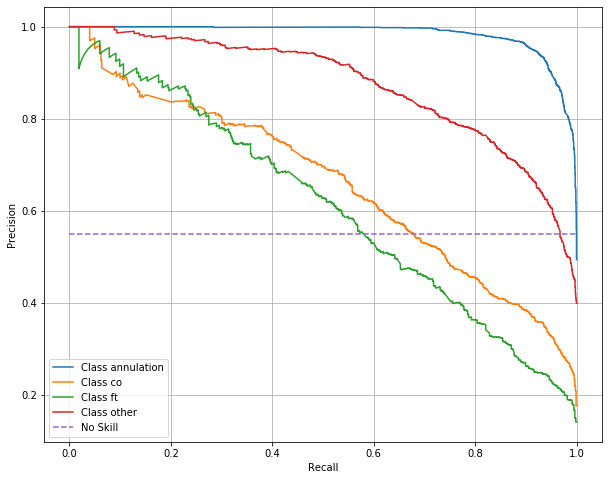



ROC AUC class annulation: 0.985
ROC AUC class co: 0.905
ROC AUC class ft: 0.911
ROC AUC class other: 0.94

ROC AUC=0.952 



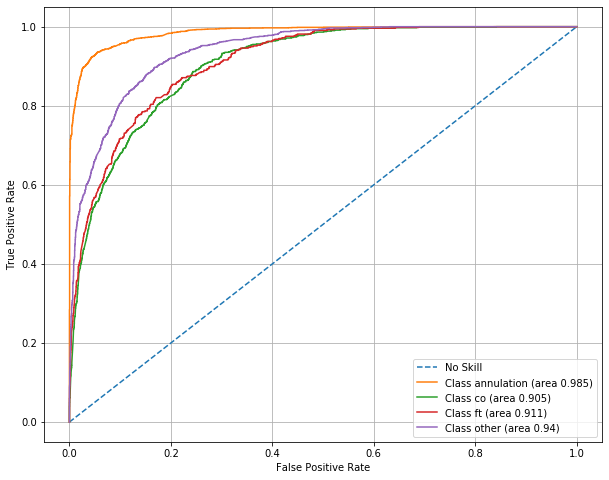


Evaluation Curves


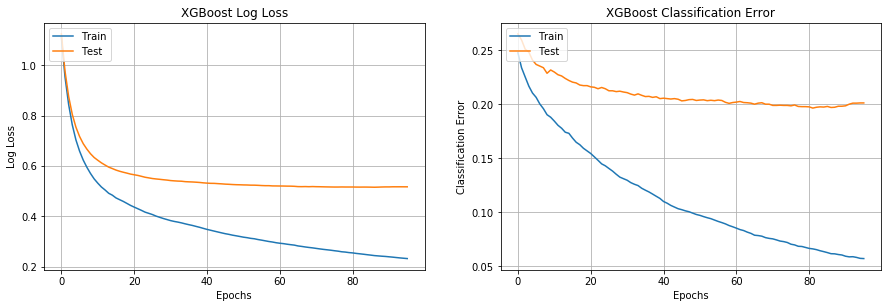



Cohen's kappa: 70.42%




In [169]:
if xgboost_classifier:
    func_precision_recall_curve(xgbs,  xvalid_tfidf.tocsc(), valid_y)
    print("\n")
    func_roc_auc_curve(xgbs,  xvalid_tfidf.tocsc(), valid_y, label=labels)
    print("\nEvaluation Curves")
    func_plot_eval_xgb(xgbs)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_tfidf.tocsc())),2)}%\n\n")

<i><h3>XGBoost for TF-IDF ngram </h3></i>


XGBoost for TF_IDF ngram


Accuracy: 78.59%

Classification Report

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2358
           1       0.64      0.51      0.57       802
           2       0.64      0.39      0.48       535
           3       0.70      0.85      0.77      1550

    accuracy                           0.79      5245
   macro avg       0.72      0.67      0.68      5245
weighted avg       0.78      0.79      0.78      5245


Confusion Matrix



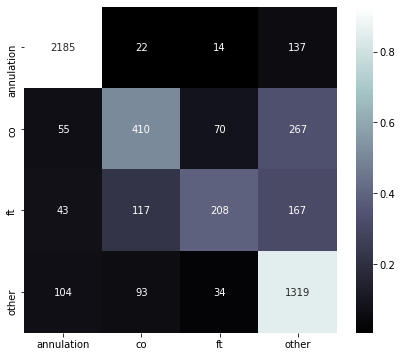

In [170]:
if xgboost_classifier:
    print("\nXGBoost for TF_IDF ngram\n")
    xgbs, pred, accuracy = func_xgb(xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)



Model class: annulation --> f1=0.921 AUC=0.980
Model class: co --> f1=0.568 AUC=0.646
Model class: ft --> f1=0.483 AUC=0.561
Model class: other --> f1=0.767 AUC=0.849




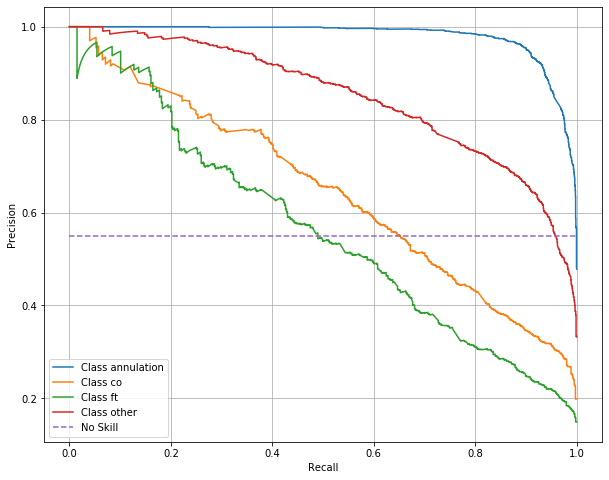



ROC AUC class annulation: 0.981
ROC AUC class co: 0.897
ROC AUC class ft: 0.896
ROC AUC class other: 0.928

ROC AUC=0.944 



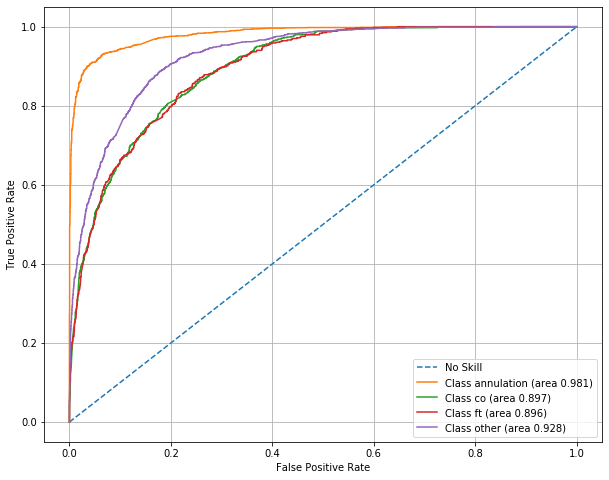


Evaluation Curves


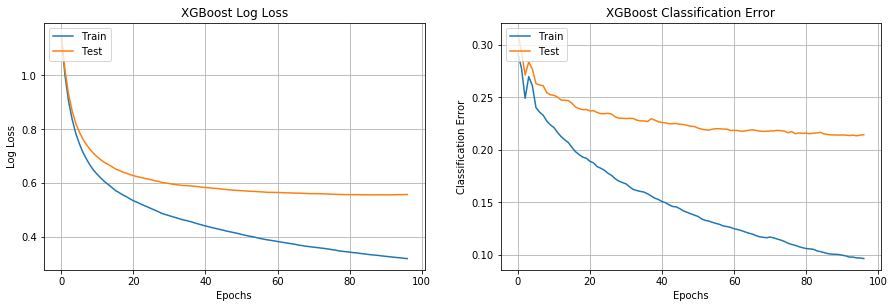



Cohen's kappa: 67.75%




In [171]:
if xgboost_classifier:
    func_precision_recall_curve(xgbs,  xvalid_tfidf_ngram, valid_y)
    print("\n")
    func_roc_auc_curve(xgbs,  xvalid_tfidf_ngram, valid_y, label=labels)
    print("\nEvaluation Curves")
    func_plot_eval_xgb(xgbs)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_tfidf_ngram)),2)}%\n\n")

<i><h3>XGBoost for TF-IDF ngram chars</h3></i>


XGBoost for TF-IDF ngram chars


Accuracy: 79.62%

Classification Report

              precision    recall  f1-score   support

  annulation       0.92      0.94      0.93      2358
          co       0.63      0.53      0.58       802
          ft       0.63      0.43      0.51       535
       other       0.72      0.84      0.78      1550

    accuracy                           0.80      5245
   macro avg       0.73      0.69      0.70      5245
weighted avg       0.79      0.80      0.79      5245


Confusion Matrix



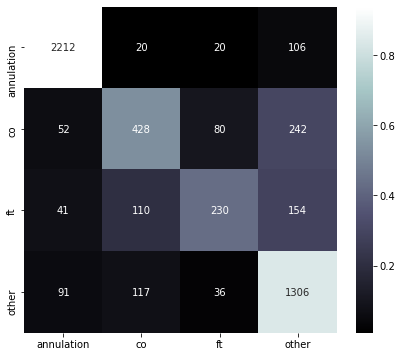

In [172]:
if xgboost_classifier:
    print("\nXGBoost for TF-IDF ngram chars\n")
    xgbs, pred, accuracy = func_xgb(xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc(), valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred,target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)



Model class: annulation --> f1=0.931 AUC=0.984
Model class: co --> f1=0.580 AUC=0.663
Model class: ft --> f1=0.511 AUC=0.588
Model class: other --> f1=0.778 AUC=0.874




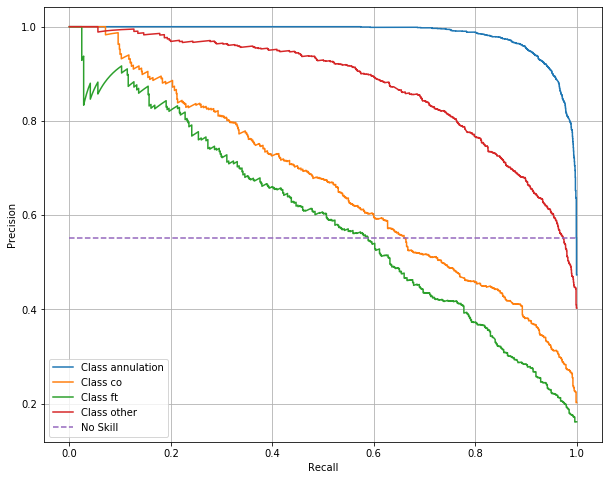



ROC AUC class annulation: 0.986
ROC AUC class co: 0.905
ROC AUC class ft: 0.91
ROC AUC class other: 0.94

ROC AUC=0.952 



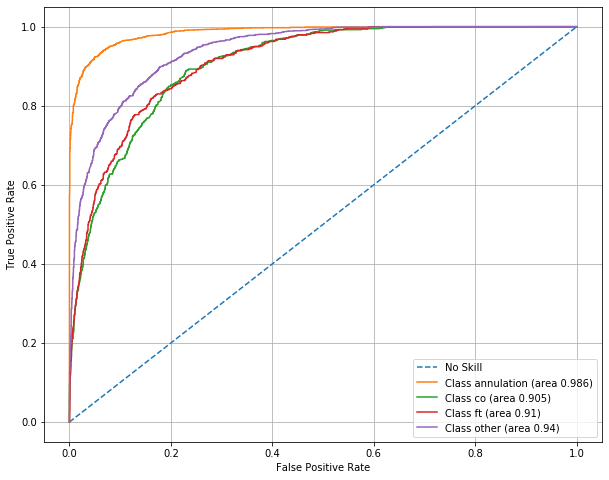


Evaluation Curves


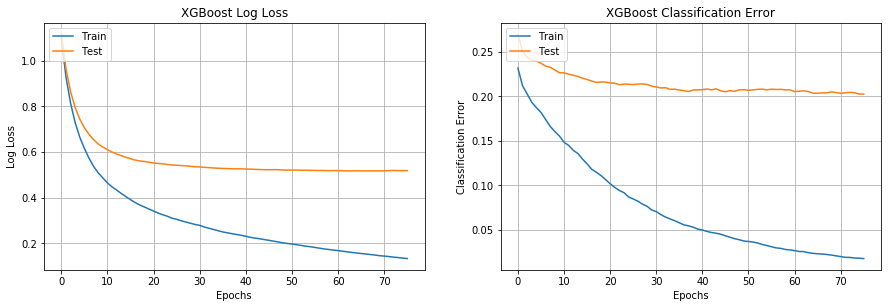



Cohen's kappa: 69.4%




In [173]:
if xgboost_classifier:
    func_precision_recall_curve(xgbs,  xvalid_tfidf_ngram_chars.tocsc(), valid_y)
    print("\n")
    func_roc_auc_curve(xgbs,  xvalid_tfidf_ngram_chars.tocsc(), valid_y, label=labels)
    print("\nEvaluation Curves")
    func_plot_eval_xgb(xgbs)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_tfidf_ngram_chars.tocsc())),2)}%\n\n")

<i><h3>XGBoost for Word Embeddings</h3></i>


XGBoost for Word Embeddings


Accuracy: 64.40%

Classification Report

              precision    recall  f1-score   support

  annulation       0.71      0.82      0.76      2358
          co       0.65      0.39      0.48       802
          ft       0.51      0.20      0.28       535
       other       0.56      0.66      0.60      1550

    accuracy                           0.64      5245
   macro avg       0.61      0.52      0.53      5245
weighted avg       0.64      0.64      0.62      5245


Confusion Matrix



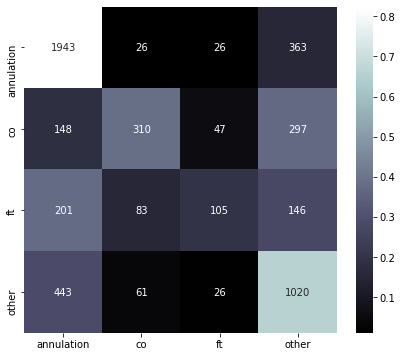

In [174]:
if xgboost_classifier:
    print("\nXGBoost for Word Embeddings\n")
    xgbs, pred, accuracy = func_xgb(train_seq_x, train_y, valid_seq_x, valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)



Model class: annulation --> f1=0.763 AUC=0.860
Model class: co --> f1=0.484 AUC=0.527
Model class: ft --> f1=0.284 AUC=0.351
Model class: other --> f1=0.604 AUC=0.639




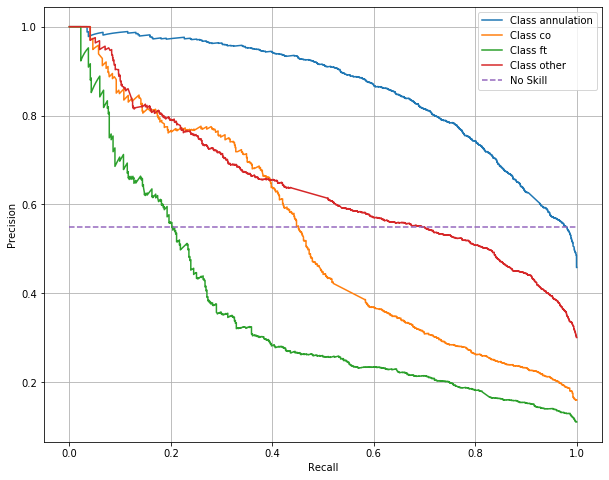



ROC AUC class annulation: 0.872
ROC AUC class co: 0.803
ROC AUC class ft: 0.775
ROC AUC class other: 0.808

ROC AUC=0.833 



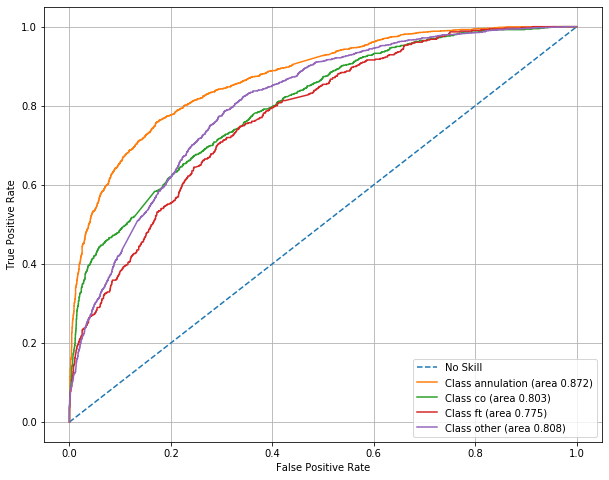


Evaluation Curves


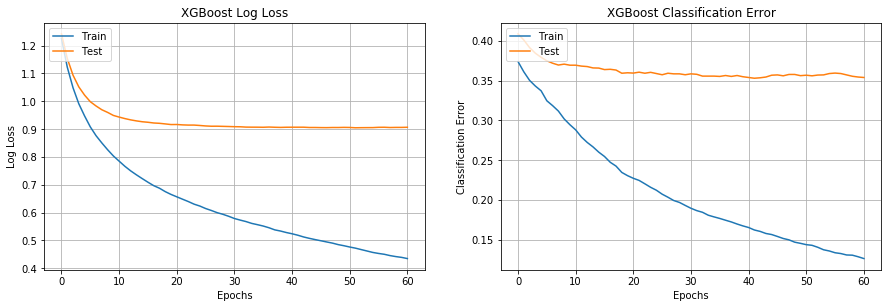



Cohen's kappa: 44.79%




In [175]:
if xgboost_classifier:
    func_precision_recall_curve(xgbs,  valid_seq_x, valid_y)
    print("\n")
    func_roc_auc_curve(xgbs,  valid_seq_x, valid_y, label=labels)
    print("\nEvaluation Curves")
    func_plot_eval_xgb(xgbs)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(valid_seq_x)),2)}%\n\n")

---

<center><h1>Deep Learning</h1></center>

---

In [176]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
check_p = tf.keras.callbacks.ModelCheckpoint("save_models/model.h5", save_best_only=True)

<h2>Shallow Neural Networks</h2>

In [177]:
def shallow_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 16)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [178]:
if deep_learning:
    model = shallow_neural_networks(word_index, pre_trained=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         81395100  
_________________________________________________________________
global_average_pooling1d (Gl (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 1204      
Total params: 81,396,304
Trainable params: 1,204
Non-trainable params: 81,395,100
_________________________________________________________________
None


In [179]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=500, callbacks=[es],
                    validation_split=0.2, verbose=False)

In [180]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)
    print(results)

164/164 [==============================] - 1s 4ms/step - loss: 0.9348 - accuracy: 0.6509
[0.9347505569458008, 0.6509056091308594]


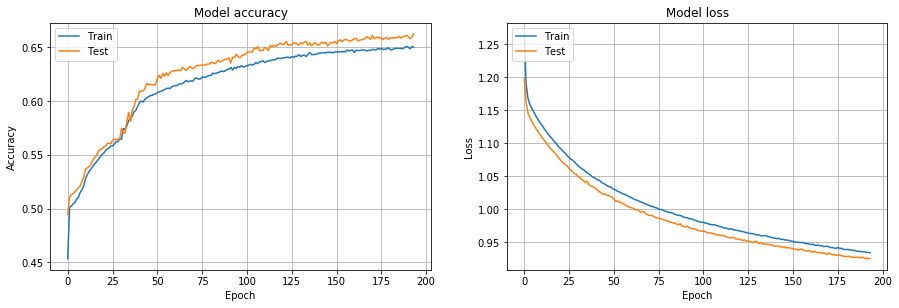

In [181]:
func_plot_history(history)

<h3>Cohen’s kappa</h3>

The function [cohen_kappa_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html#sklearn.metrics.cohen_kappa_score) computes [Cohen’s kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa) statistic. This measure is intended to compare labelings by different human annotators, not a classifier versus a ground truth.

The kappa score (see docstring) is a number between -1 and 1. Scores above .8 are generally considered good agreement; zero or lower means no agreement (practically random labels).

Kappa scores can be computed for binary or multiclass problems, but not for multilabel problems (except by manually computing a per-label score) and not for more than two annotators.

In [182]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, model.predict(valid_seq_x).argmax(axis=-1)),2)}%")

Cohen's kappa: 45.44%


<h3>Confusion Matrix</h3>

In [183]:
if deep_learning:
    matrices = func_confusion_matrix(model, valid_y, valid_seq_x)


Confusion matrix for classe: annulation 

                 Predicted Negative  Predicted Positive
Actual Negative                2086                 801
Actual Positive                 358                2000



Confusion matrix for classe: co 

                 Predicted Negative  Predicted Positive
Actual Negative                4299                 144
Actual Positive                 553                 249



Confusion matrix for classe: ft 

                 Predicted Negative  Predicted Positive
Actual Negative                4604                 106
Actual Positive                 454                  81



Confusion matrix for classe: other 

                 Predicted Negative  Predicted Positive
Actual Negative                2915                 780
Actual Positive                 466                1084





Confusion Matrix



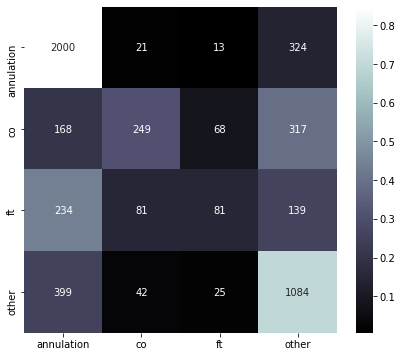

In [184]:
if deep_learning:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [185]:
if deep_learning:
    print(classification_report(valid_y, model.predict(valid_seq_x).argmax(axis=-1), target_names=labels))

              precision    recall  f1-score   support

  annulation       0.71      0.85      0.78      2358
          co       0.63      0.31      0.42       802
          ft       0.43      0.15      0.22       535
       other       0.58      0.70      0.64      1550

    accuracy                           0.65      5245
   macro avg       0.59      0.50      0.51      5245
weighted avg       0.63      0.65      0.62      5245



<h3>ROC and AUC Curve</h3>

Instructions for updating:
Please use `model.predict()` instead.


2020-04-20 00:31:59 WARNING: From <ipython-input-166-785c1e754989>:7: Sequential.predict_proba (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use `model.predict()` instead.


ROC AUC class annulation: 0.644
ROC AUC class co: 0.675
ROC AUC class ft: 0.666
ROC AUC class other: 0.576

ROC AUC=0.631 



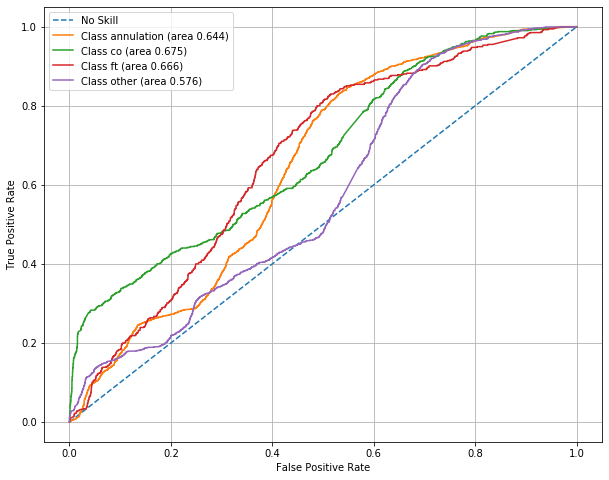

In [186]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>



Model class: annulation --> f1=0.775 AUC=0.542
Model class: co --> f1=0.417 AUC=0.373
Model class: ft --> f1=0.224 AUC=0.158
Model class: other --> f1=0.635 AUC=0.372




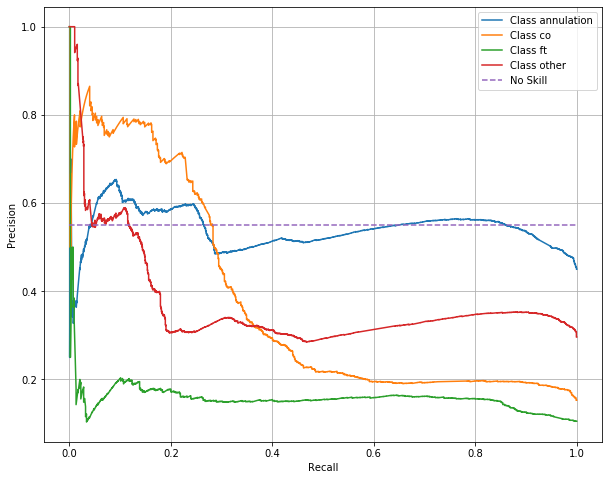

In [187]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h3>Balanced Accuracy</h3>

Compute the balanced accuracy

The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.

The best value is 1 and the worst value is 0 when adjusted=False

In [188]:
if deep_learning:
    print(f"The balanced accuracy is : {round(100*balanced_accuracy_score(valid_y, model.predict(valid_seq_x).argmax(axis=-1)),2)}%")

The balanced accuracy is : 50.24%


In [189]:
if deep_learning:
    print(f"The Zero-one Loss is : {round(100*zero_one_loss(valid_y, model.predict(valid_seq_x).argmax(axis=-1)),2)}%")

The Zero-one Loss is : 34.91%


In [190]:
if deep_learning:
    explained_variance_score(valid_y, model.predict(valid_seq_x).argmax(axis=-1))

<h2>Deep Neural Networks</h2>

In [191]:
def deep_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [192]:
if deep_learning:
    model = deep_neural_networks(word_index, pre_trained=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         27131700  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 27,133,384
Trainable params: 27,133,384
Non-trainable params: 0
_________________________________________________________________
None


In [193]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
394/394 [==============================] - 391s 992ms/step - loss: 1.2302 - accuracy: 0.4914 - val_loss: 1.1435 - val_accuracy: 0.5745
Epoch 2/50
394/394 [==============================] - 392s 994ms/step - loss: 1.0933 - accuracy: 0.6523 - val_loss: 1.0536 - val_accuracy: 0.6835
Epoch 3/50
394/394 [==============================] - 390s 990ms/step - loss: 1.0255 - accuracy: 0.6981 - val_loss: 1.0246 - val_accuracy: 0.7064
Epoch 4/50
394/394 [==============================] - 387s 982ms/step - loss: 0.9900 - accuracy: 0.7346 - val_loss: 1.0097 - val_accuracy: 0.7194
Epoch 5/50
394/394 [==============================] - 391s 992ms/step - loss: 0.9644 - accuracy: 0.7599 - val_loss: 1.0047 - val_accuracy: 0.7181
Epoch 6/50
394/394 [==============================] - 391s 992ms/step - loss: 0.9458 - accuracy: 0.7726 - val_loss: 0.9961 - val_accuracy: 0.7229
Epoch 7/50
394/394 [==============================] - 388s 986ms/step - loss: 0.9299 - accuracy: 0.7862 - val_loss: 0.9945 -

In [194]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

164/164 [==============================] - 0s 2ms/step - loss: 0.9863 - accuracy: 0.7319
[0.986257016658783, 0.7319352030754089]


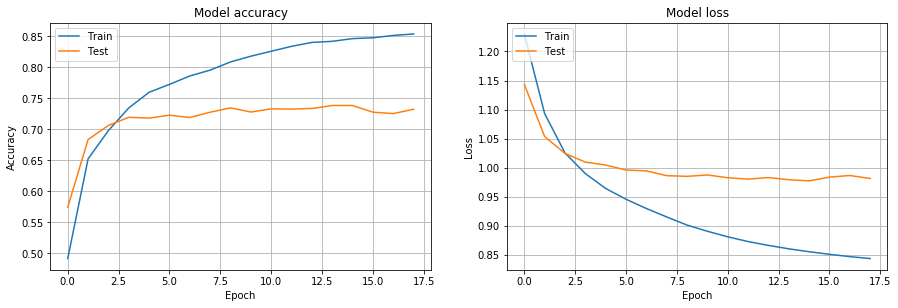

In [195]:
if deep_learning:
    func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [196]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, model.predict(valid_seq_x).argmax(axis=-1)),2)}%")

Cohen's kappa: 59.65%


<h3>Confusion Matrix</h3>

In [197]:
if deep_learning:
    matrices = func_confusion_matrix(model, valid_y, valid_seq_x)


Confusion matrix for classe: annulation 

                 Predicted Negative  Predicted Positive
Actual Negative                2621                 266
Actual Positive                 273                2085



Confusion matrix for classe: co 

                 Predicted Negative  Predicted Positive
Actual Negative                3920                 523
Actual Positive                 340                 462



Confusion matrix for classe: ft 

                 Predicted Negative  Predicted Positive
Actual Negative                4686                  24
Actual Positive                 503                  32



Confusion matrix for classe: other 

                 Predicted Negative  Predicted Positive
Actual Negative                3102                 593
Actual Positive                 290                1260





Confusion Matrix



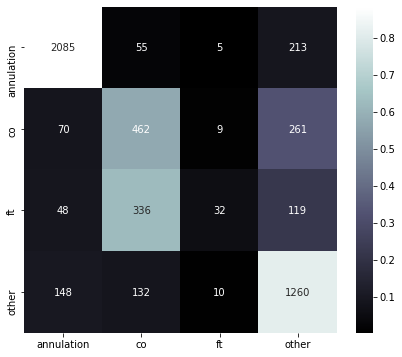

In [198]:
if deep_learning:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [199]:
if deep_learning:
    print(classification_report(valid_y, model.predict(valid_seq_x).argmax(-1), target_names=labels) )

              precision    recall  f1-score   support

  annulation       0.89      0.88      0.89      2358
          co       0.47      0.58      0.52       802
          ft       0.57      0.06      0.11       535
       other       0.68      0.81      0.74      1550

    accuracy                           0.73      5245
   macro avg       0.65      0.58      0.56      5245
weighted avg       0.73      0.73      0.71      5245



<h3>ROC and AUC Curve</h3>

ROC AUC class annulation: 0.952
ROC AUC class co: 0.836
ROC AUC class ft: 0.832
ROC AUC class other: 0.902

ROC AUC=0.907 



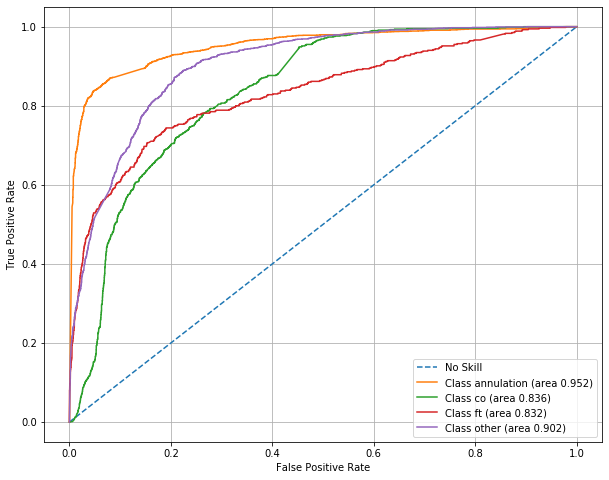

In [200]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>



Model class: annulation --> f1=0.886 AUC=0.952
Model class: co --> f1=0.517 AUC=0.389
Model class: ft --> f1=0.108 AUC=0.531
Model class: other --> f1=0.741 AUC=0.796




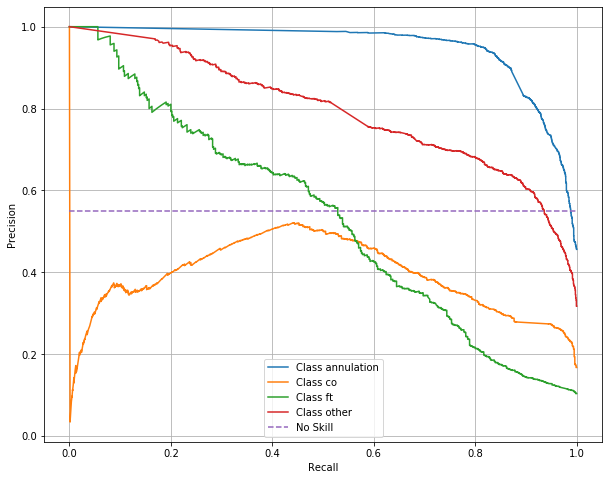

In [201]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Deep Neural Networks variation 1</h2>

In [202]:
def deep_neural_networks_var1(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 16)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1  if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [203]:
if deep_learning:
    model = deep_neural_networks_var1(word_index, pre_trained=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          4341072   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 4,341,684
Trainable params: 4,341,684
Non-trainable params: 0
_________________________________________________________________
None


In [204]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=500, callbacks=[es],
                    validation_split=0.2)

Epoch 1/500
394/394 [==============================] - 22s 57ms/step - loss: 1.2528 - accuracy: 0.4833 - val_loss: 1.1606 - val_accuracy: 0.5691
Epoch 2/500
394/394 [==============================] - 23s 59ms/step - loss: 1.1141 - accuracy: 0.6240 - val_loss: 1.0676 - val_accuracy: 0.6762
Epoch 3/500
394/394 [==============================] - 22s 56ms/step - loss: 1.0352 - accuracy: 0.6874 - val_loss: 1.0281 - val_accuracy: 0.6927
Epoch 4/500
394/394 [==============================] - 22s 57ms/step - loss: 0.9960 - accuracy: 0.7154 - val_loss: 1.0169 - val_accuracy: 0.7007
Epoch 5/500
394/394 [==============================] - 23s 58ms/step - loss: 0.9718 - accuracy: 0.7338 - val_loss: 1.0085 - val_accuracy: 0.7026
Epoch 6/500
394/394 [==============================] - 22s 56ms/step - loss: 0.9561 - accuracy: 0.7555 - val_loss: 1.0029 - val_accuracy: 0.7159
Epoch 7/500
394/394 [==============================] - 24s 61ms/step - loss: 0.9362 - accuracy: 0.7800 - val_loss: 0.9939 - val_ac

In [205]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

164/164 [==============================] - 0s 2ms/step - loss: 0.9920 - accuracy: 0.7190
[0.9920017719268799, 0.7189704775810242]


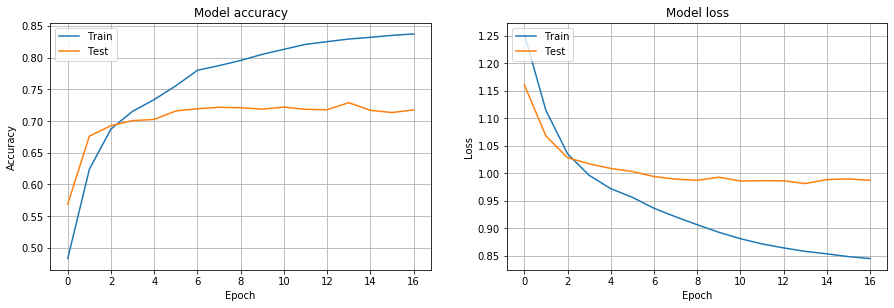

In [206]:
if deep_learning:
    func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [207]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, model.predict(valid_seq_x).argmax(axis=-1)),2)}%")

Cohen's kappa: 58.0%


<h3>Confusion Matrix</h3>

In [208]:
if deep_learning:
    matrices=func_confusion_matrix(model, valid_y, valid_seq_x)


Confusion matrix for classe: annulation 

                 Predicted Negative  Predicted Positive
Actual Negative                2645                 242
Actual Positive                 292                2066



Confusion matrix for classe: co 

                 Predicted Negative  Predicted Positive
Actual Negative                3764                 679
Actual Positive                 287                 515



Confusion matrix for classe: ft 

                 Predicted Negative  Predicted Positive
Actual Negative                4710                   0
Actual Positive                 535                   0



Confusion matrix for classe: other 

                 Predicted Negative  Predicted Positive
Actual Negative                3142                 553
Actual Positive                 360                1190





Confusion Matrix



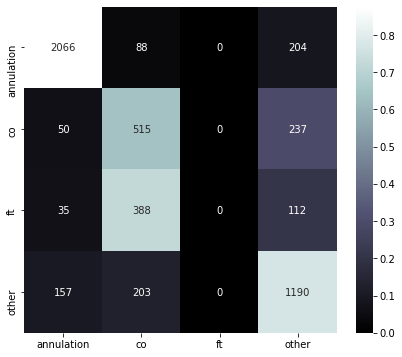

In [209]:
if deep_learning:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [210]:
if deep_learning:
    print(classification_report(valid_y, model.predict(valid_seq_x).argmax(axis=-1), target_names=labels))

              precision    recall  f1-score   support

  annulation       0.90      0.88      0.89      2358
          co       0.43      0.64      0.52       802
          ft       0.00      0.00      0.00       535
       other       0.68      0.77      0.72      1550

    accuracy                           0.72      5245
   macro avg       0.50      0.57      0.53      5245
weighted avg       0.67      0.72      0.69      5245



/home/chris/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h3>ROC and AUC Curve</h3>

ROC AUC class annulation: 0.948
ROC AUC class co: 0.832
ROC AUC class ft: 0.827
ROC AUC class other: 0.898

ROC AUC=0.903 



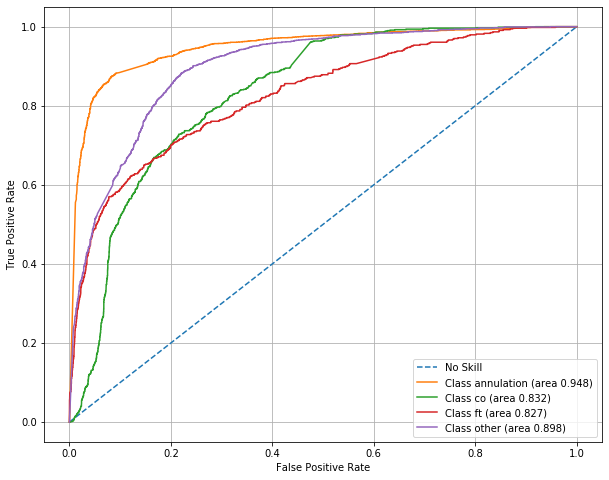

In [211]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>



Model class: annulation --> f1=0.886 AUC=0.944
Model class: co --> f1=0.516 AUC=0.379
Model class: ft --> f1=0.000 AUC=0.482
Model class: other --> f1=0.723 AUC=0.788




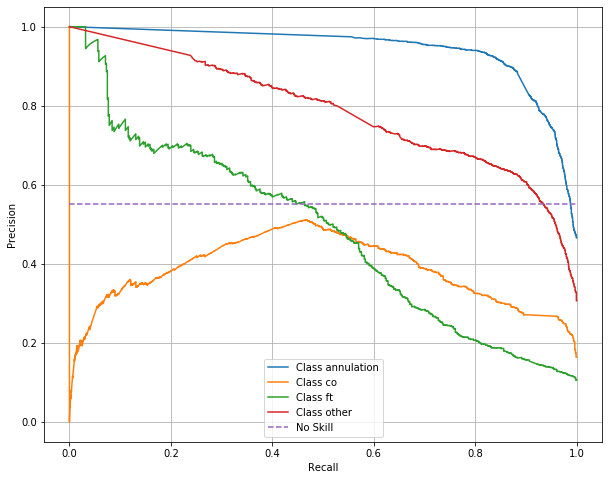

In [212]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Deep Neural Networks variation 2</h2>

In [213]:
def deep_neural_networks_var2(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 32)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1  if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model


In [214]:
if deep_learning:
    model = deep_neural_networks_var2(word_index, pre_trained=False)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          8682144   
_________________________________________________________________
global_average_pooling1d_3 ( (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 68        
Total params: 8,683,796
Trainable params: 8,683,796
Non-trainable params: 0
_________________________________________________________________
None


In [215]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
394/394 [==============================] - 72s 183ms/step - loss: 1.2250 - accuracy: 0.5153 - val_loss: 1.1201 - val_accuracy: 0.6155
Epoch 2/50
394/394 [==============================] - 71s 180ms/step - loss: 1.0735 - accuracy: 0.6621 - val_loss: 1.0392 - val_accuracy: 0.6953
Epoch 3/50
394/394 [==============================] - 71s 180ms/step - loss: 1.0005 - accuracy: 0.7232 - val_loss: 1.0099 - val_accuracy: 0.6972
Epoch 4/50
394/394 [==============================] - 71s 180ms/step - loss: 0.9645 - accuracy: 0.7612 - val_loss: 0.9968 - val_accuracy: 0.7420
Epoch 5/50
394/394 [==============================] - 70s 177ms/step - loss: 0.9405 - accuracy: 0.7895 - val_loss: 0.9929 - val_accuracy: 0.7401
Epoch 6/50
394/394 [==============================] - 70s 179ms/step - loss: 0.9224 - accuracy: 0.8041 - val_loss: 0.9915 - val_accuracy: 0.7305
Epoch 7/50
394/394 [==============================] - 70s 179ms/step - loss: 0.9096 - accuracy: 0.8106 - val_loss: 0.9902 - val_ac

In [216]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

164/164 [==============================] - 0s 2ms/step - loss: 0.9923 - accuracy: 0.7239
[0.9923130869865417, 0.7239275574684143]


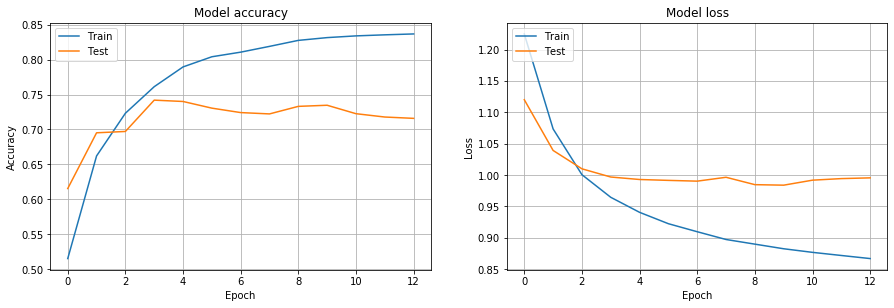

In [217]:
if deep_learning:
    func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [218]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, model.predict(valid_seq_x).argmax(-1)),2)}%")

Cohen's kappa: 57.88%


<h3>Confusion Matrix</h3>

In [219]:
if deep_learning:
    matrices = func_confusion_matrix(model, valid_y, valid_seq_x)


Confusion matrix for classe: annulation 

                 Predicted Negative  Predicted Positive
Actual Negative                2430                 457
Actual Positive                 173                2185



Confusion matrix for classe: co 

                 Predicted Negative  Predicted Positive
Actual Negative                3884                 559
Actual Positive                 324                 478



Confusion matrix for classe: ft 

                 Predicted Negative  Predicted Positive
Actual Negative                4706                   4
Actual Positive                 529                   6



Confusion matrix for classe: other 

                 Predicted Negative  Predicted Positive
Actual Negative                3267                 428
Actual Positive                 422                1128





Confusion Matrix



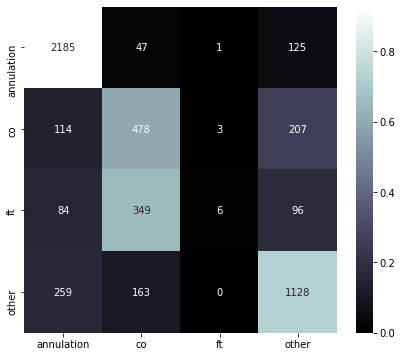

In [220]:
if deep_learning:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [221]:
if deep_learning:
    print(classification_report(valid_y,  model.predict(valid_seq_x).argmax(-1), target_names=labels))

              precision    recall  f1-score   support

  annulation       0.83      0.93      0.87      2358
          co       0.46      0.60      0.52       802
          ft       0.60      0.01      0.02       535
       other       0.72      0.73      0.73      1550

    accuracy                           0.72      5245
   macro avg       0.65      0.57      0.54      5245
weighted avg       0.72      0.72      0.69      5245



<h3>ROC and AUC Curve</h3>

ROC AUC class annulation: 0.957
ROC AUC class co: 0.842
ROC AUC class ft: 0.832
ROC AUC class other: 0.904

ROC AUC=0.911 



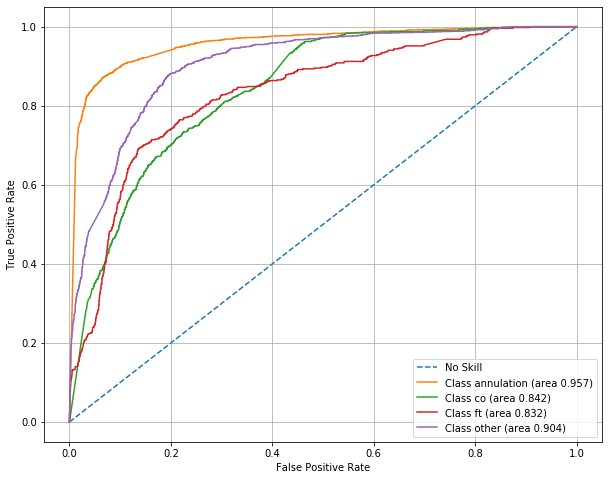

In [222]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>



Model class: annulation --> f1=0.874 AUC=0.955
Model class: co --> f1=0.520 AUC=0.523
Model class: ft --> f1=0.022 AUC=0.404
Model class: other --> f1=0.726 AUC=0.804




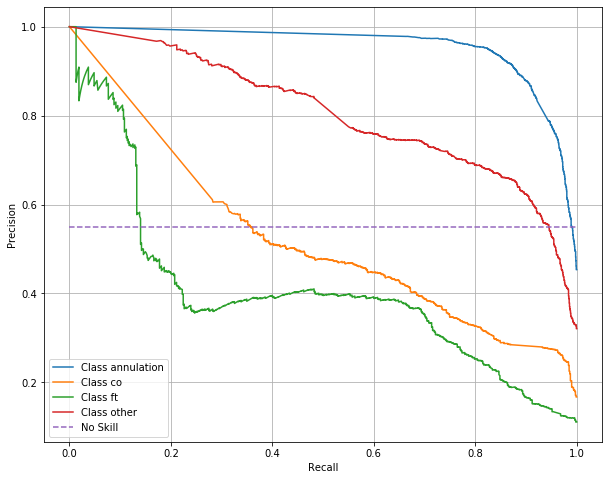

In [223]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Recurent Neural Network - RNN</h2>

In [224]:
def create_rnn_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [225]:
if deep_learning:
    model = create_rnn_model(word_index, pre_trained=False )


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         27131700  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 100)         20100     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 404       
Total params: 27,172,304
Trainable params: 27,172,304
Non-trainable params: 0
_________________________________________________________________
None


In [226]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Epoch 1/50
394/394 [==============================] - 419s 1s/step - loss: 1.1644 - accuracy: 0.5619 - val_loss: 1.1341 - val_accuracy: 0.5875
Epoch 2/50
394/394 [==============================] - 419s 1s/step - loss: 1.0554 - accuracy: 0.6765 - val_loss: 1.1278 - val_accuracy: 0.6028
Epoch 3/50
394/394 [==============================] - 418s 1s/step - loss: 1.0108 - accuracy: 0.7228 - val_loss: 1.1326 - val_accuracy: 0.5771
Epoch 4/50
394/394 [==============================] - 432s 1s/step - loss: 1.2379 - accuracy: 0.4819 - val_loss: 1.1998 - val_accuracy: 0.5237
Epoch 5/50
394/394 [==============================] - 418s 1s/step - loss: 1.1008 - accuracy: 0.6412 - val_loss: 1.1416 - val_accuracy: 0.5888


In [227]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

164/164 [==============================] - 7s 40ms/step - loss: 1.1274 - accuracy: 0.6004
[1.1273889541625977, 0.6003813147544861]


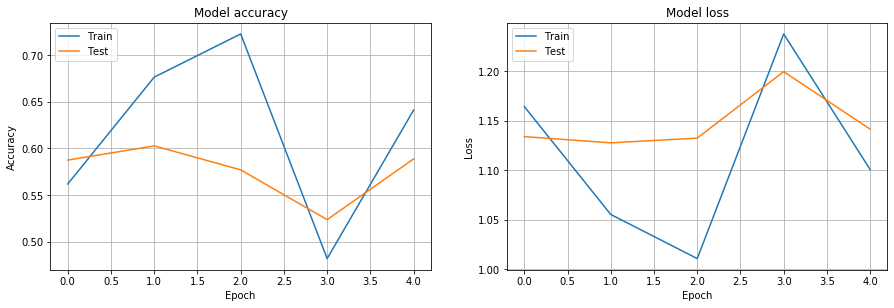

In [228]:
if deep_learning:
    func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [229]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, model.predict(valid_seq_x).argmax(-1)),2)}%")

Cohen's kappa: 38.85%


<h3>Confusion Matrix</h3>

In [230]:
if deep_learning:
    matrices = func_confusion_matrix(model, valid_y, valid_seq_x)


Confusion matrix for classe: annulation 

                 Predicted Negative  Predicted Positive
Actual Negative                2229                 658
Actual Positive                 646                1712



Confusion matrix for classe: co 

                 Predicted Negative  Predicted Positive
Actual Negative                4144                 299
Actual Positive                 475                 327



Confusion matrix for classe: ft 

                 Predicted Negative  Predicted Positive
Actual Negative                4679                  31
Actual Positive                 522                  13



Confusion matrix for classe: other 

                 Predicted Negative  Predicted Positive
Actual Negative                2587                1108
Actual Positive                 453                1097




<h3>Classification repport</h3>

In [231]:
if deep_learning:
    print(classification_report(valid_y,  model.predict(valid_seq_x).argmax(-1), target_names=labels))

              precision    recall  f1-score   support

  annulation       0.72      0.73      0.72      2358
          co       0.52      0.41      0.46       802
          ft       0.30      0.02      0.04       535
       other       0.50      0.71      0.58      1550

    accuracy                           0.60      5245
   macro avg       0.51      0.47      0.45      5245
weighted avg       0.58      0.60      0.57      5245



<h3>ROC and AUC Curve</h3>

ROC AUC class annulation: 0.824
ROC AUC class co: 0.664
ROC AUC class ft: 0.727
ROC AUC class other: 0.756

ROC AUC=0.770 



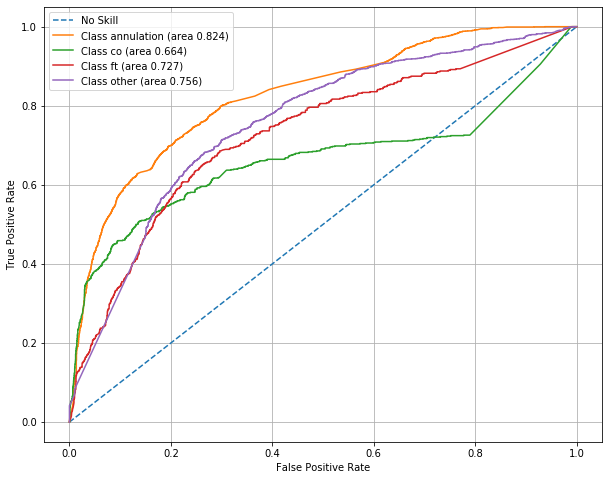

In [232]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>



Model class: annulation --> f1=0.724 AUC=0.790
Model class: co --> f1=0.458 AUC=0.423
Model class: ft --> f1=0.045 AUC=0.255
Model class: other --> f1=0.584 AUC=0.583




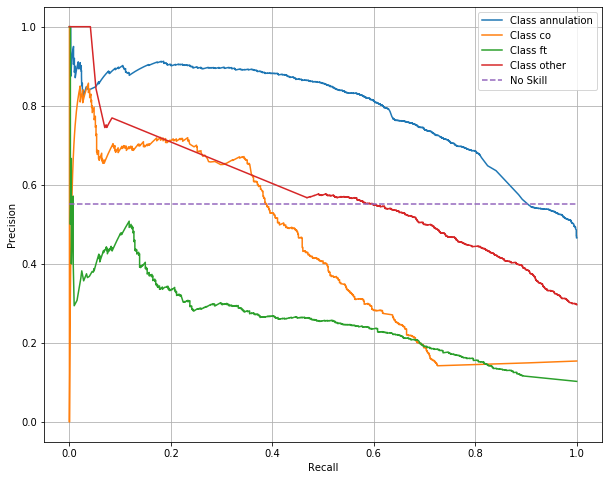

In [233]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Convolutional Neural Network</h2>

In [ ]:
def create_conv_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(250, 5, activation='relu', padding='same'), # padding='same'
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(150, 5, activation='relu', padding='same'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(50, 5, activation='relu', padding='same'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),

    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
if deep_learning:
    model = create_conv_model(word_index,  pre_trained=True)

In [ ]:
if deep_learning:
    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

In [ ]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

In [ ]:
if deep_learning:
    func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [ ]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, model.predict(valid_seq_x).argmax(-1)),2)}%")

<h3>Confusion Matrix</h3>

In [ ]:
if deep_learning:
    matrices = func_confusion_matrix(model, valid_y, valid_seq_x)

In [ ]:
if deep_learning:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [ ]:
if deep_learning:
    print(classification_report(valid_y, model.predict(valid_seq_x);argmax(-1), target_names=labels))

<h3>ROC and AUC Curve</h3>

In [ ]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Recurrent Neural Network – LSTM</h2>

In [244]:
def create_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index)+1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.LSTM(100),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [245]:
if deep_learning:
    model = create_lstm_model(word_index, pre_trained=True)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 300)         81395100  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 404       
Total params: 81,555,904
Trainable params: 160,804
Non-trainable params: 81,395,100
_________________________________________________________________
None
Epoch 1/50
394/394 [==============================] - 95s 242ms/step - loss: 1.1967 - accuracy: 0.5270 - val_loss: 1.1507 - val_accuracy: 0.5818
Epoch 2/50
394/394 [==============================] - 99s 252ms/step - loss: 1.1780 

In [246]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

164/164 [==============================] - 14s 86ms/step - loss: 1.1511 - accuracy: 0.5664
[1.1511493921279907, 0.5664442181587219]


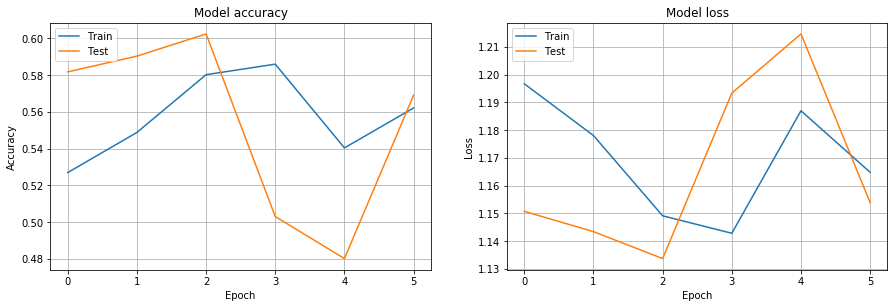

In [247]:
if deep_learning:
    func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [248]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, model.predict(valid_seq_x).argmax(-1)),2)}%")

Cohen's kappa: 29.0%


<h3>Confusion Matrix</h3>

In [249]:
if deep_learning:
    matrices = func_confusion_matrix(model, valid_y, valid_seq_x)


Confusion matrix for classe: annulation 

                 Predicted Negative  Predicted Positive
Actual Negative                1346                1541
Actual Positive                 287                2071



Confusion matrix for classe: co 

                 Predicted Negative  Predicted Positive
Actual Negative                4321                 122
Actual Positive                 586                 216



Confusion matrix for classe: ft 

                 Predicted Negative  Predicted Positive
Actual Negative                4658                  52
Actual Positive                 503                  32



Confusion matrix for classe: other 

                 Predicted Negative  Predicted Positive
Actual Negative                3136                 559
Actual Positive                 898                 652





Confusion Matrix



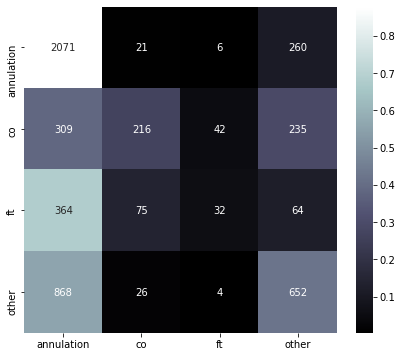

In [250]:
if deep_learning:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [251]:
if deep_learning:
    print(classification_report(valid_y, model.predict(valid_seq_x).argmax(-1), target_names=labels))

              precision    recall  f1-score   support

  annulation       0.57      0.88      0.69      2358
          co       0.64      0.27      0.38       802
          ft       0.38      0.06      0.10       535
       other       0.54      0.42      0.47      1550

    accuracy                           0.57      5245
   macro avg       0.53      0.41      0.41      5245
weighted avg       0.55      0.57      0.52      5245



<h3>ROC and AUC Curve</h3>

ROC AUC class annulation: 0.758
ROC AUC class co: 0.732
ROC AUC class ft: 0.603
ROC AUC class other: 0.739

ROC AUC=0.733 



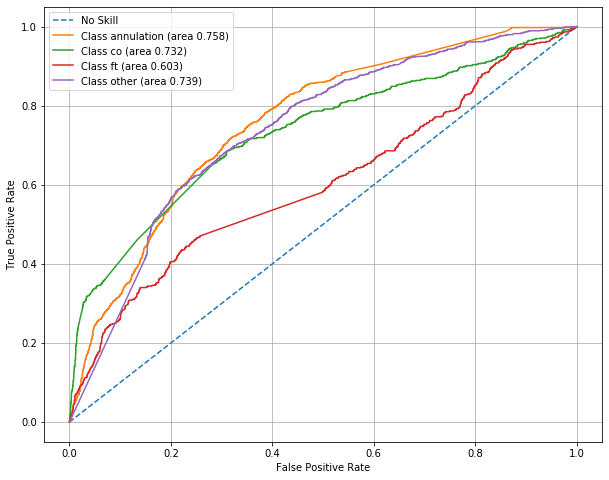

In [252]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>



Model class: annulation --> f1=0.694 AUC=0.686
Model class: co --> f1=0.379 AUC=0.432
Model class: ft --> f1=0.103 AUC=0.179
Model class: other --> f1=0.472 AUC=0.589




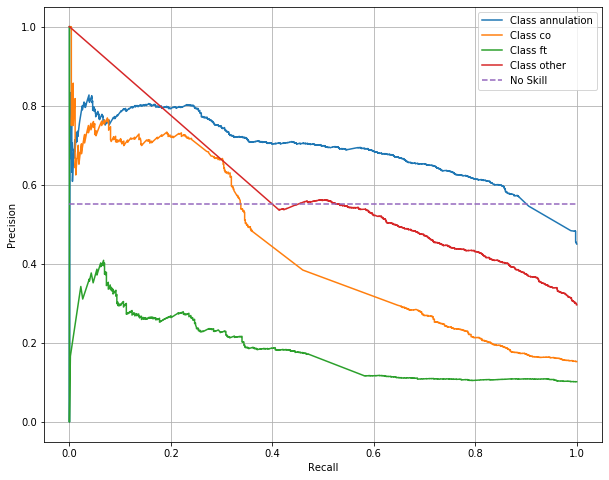

In [253]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>CNN – LSTM</h2>

In [254]:
def create_cnn_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.LSTM(100),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
if deep_learning:
    model = create_cnn_lstm_model(word_index, pre_trained=False)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         27131700  
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 128)         64128     
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 404       
Total params: 27,287,832
Trainable params: 27,287,832
Non-trainable params: 0
_________________________________________

In [ ]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

In [ ]:
if deep_learning:
    func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [ ]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y,  model.predict(valid_seq_x).argmax(-1)),2)}%")

<h3>Confusion Matrix</h3>

In [ ]:
if deep_learning:
    matrices= func_confusion_matrix(model, valid_y, valid_seq_x)

In [ ]:
if deep_learning:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [ ]:
if deep_learning:
    print(classification_report(valid_y, model.predict(valid_seq_x).argmax(-1), target_names=labels))

<h3>ROC and AUC Curve</h3>

In [ ]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Recurrent Neural Network – GRU</h2>

tf.keras.layers.GRU(
    units, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
    kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
    bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    recurrent_constraint=None, bias_constraint=None, dropout=0.0,
    recurrent_dropout=0.0, implementation=2, return_sequences=False,
    return_state=False, go_backwards=False, stateful=False, unroll=False,
    time_major=False, reset_after=True, **kwargs
)

In [ ]:
def create_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.GRU(100),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
if deep_learning:
    model = create_gru_model(word_index, pre_trained=False )


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

In [ ]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

In [ ]:
if deep_learning:
    func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [ ]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, model.predict(valid_seq_x).argmax(-1)),2)}%")

<h3>Confusion Matrix</h3>

In [ ]:
if deep_learning:
    matrices = func_confusion_matrix(model, valid_y, valid_seq_x)

In [ ]:
if deep_learning:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [ ]:
if deep_learning:
    print(classification_report(valid_y,  model.predict(valid_seq_x).argmax(-1), target_names=labels))

<h3>ROC and AUC Curve</h3>

In [ ]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Bidirectional RNN</h2>

In [ ]:
def create_bidirec_rnn_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.SimpleRNN(100, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(100)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
if deep_learning:
    model = create_bidirec_rnn_model(word_index)
    
    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

In [ ]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

In [ ]:
if deep_learning:
    func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [ ]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y,  model.predict(valid_seq_x).argmax(-1)),2)}%")

<h3>Confusion Matrix</h3>

In [ ]:
if deep_learning:
    matrices = func_confusion_matrix(model, valid_y, valid_seq_x)

In [ ]:
if deep_learning:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [ ]:
if deep_learning:
    print(classification_report(valid_y, model.predict(valid_seq_x).argmax(-1), target_names=labels))

<h3>ROC and AUC Curve</h3>

In [ ]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Bidirectional LSTM</h2>

In [ ]:
def create_bidirec_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.LSTM(100)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
if deep_learning:
    model = create_bidirec_lstm_model(word_index, pre_trained=False)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

In [ ]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

In [ ]:
if deep_learning:
    func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [ ]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, model.predict(valid_seq_x).argmax(-1)),2)}%")

<h3>Confusion Matrix</h3>

In [ ]:
if deep_learning:
    matrices=func_confusion_matrix(model, valid_y, valid_seq_x)

In [ ]:
if deep_learning:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [ ]:
if deep_learning:
    print(classification_report(valid_y,  model.predict(valid_seq_x).argmax(-1), target_names=labels))

<h3>ROC and AUC Curve</h3>

In [ ]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Bidirectional GRU</h2>

In [ ]:
def create_bidirec_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.GRU(100)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
if deep_learning:
    model = create_bidirec_gru_model(word_index, pre_trained=False)#, embedding_matrix=embedding_matrix, pre_trained=True)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

In [ ]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

In [ ]:
if deep_learning:
    func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [ ]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, model.predict(valid_seq_x).argmax(-1)),2)}%")

<h3>Confusion Matrix</h3>

In [ ]:
if deep_learning:
    matrices = func_confusion_matrix(model,valid_y, valid_seq_x)

In [ ]:
if deep_learning:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [ ]:
if deep_learning:
    print(classification_report(valid_y,  model.predict(valid_seq_x).argmax(-1), target_names=labels))

<h3>ROC and AUC Curve</h3>

In [ ]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Recurrent Convolutional Neural Network</h2>

In [ ]:
pre_trained = False

In [ ]:
def create_rcnn(X, word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300,input_length=X.shape[1], weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(100,return_sequences=True)),
    keras.layers.Convolution1D(100, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
if deep_learning:
    model = create_rcnn(train_seq_x, word_index,  pre_trained = pre_trained)


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

In [ ]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

In [ ]:
if deep_learning:
    func_plot_history(history)

In [ ]:
if deep_learning:
    model = create_rcnn(train_seq_x, word_index,  pre_trained = pre_trained)


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    
    func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [ ]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, model.predict(valid_seq_x).argmax(-1)),2)}%")

<h3>Confusion Matrix</h3>

In [ ]:
if deep_learning:
    matrices=func_confusion_matrix(model, valid_y, valid_seq_x)

In [ ]:
if deep_learning:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [ ]:
if deep_learning:
    print(classification_report(valid_y, model.predict(valid_seq_x).argmax(-1), target_names=labels))

<h3>ROC and AUC Curve</h3>

In [ ]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Recurrent Convolutional Neural Network variation 1</h2>

In [ ]:
def create_rcnn_var1(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.LSTM(100,return_sequences=True)),
    keras.layers.Convolution1D(100, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
if deep_learning:
    model = create_rcnn_var1(word_index, pre_trained = True)


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

In [ ]:
if deep_learning:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)

In [ ]:
if deep_learning:
    func_plot_history(history)

In [ ]:
if deep_learning:
    model = create_rcnn_var1(word_index, pre_trained = False)


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)
    
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    func_plot_history(history)

<h3>Cohen’s kappa</h3>

In [ ]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, model.predict(valid_seq_x).argmax(-1)),2)}%")

<h3>Confusion Matrix</h3>

In [ ]:
if deep_learning:
    matrices = func_confusion_matrix(model, valid_y, valid_seq_x)

In [ ]:
if deep_learning:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [ ]:
if deep_learning:
    print(classification_report(valid_y, model.predict(valid_seq_x).argmax(-1), target_names=labels))

<h3>ROC and AUC Curve</h3>

In [ ]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Recurrent Convulational Neural Network variation 2</h2>

In [ ]:
def create_rcnn_var2(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(100,return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.GRU(100,return_sequences=True)),
    keras.layers.Convolution1D(100, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
if deep_learning:
    model = create_rcnn_var1(word_index,  pre_trained = False)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

<h3>Cohen’s kappa</h3>

In [ ]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, model.predict(valid_seq_x).argmax(-1)),2)}%")

<h3>Confusion Matrix</h3>

In [ ]:
if deep_learning:
    matrices = func_confusion_matrix(model, valid_y, valid_seq_x)

In [ ]:
if deep_learning:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [ ]:
if deep_learning:
    print(classification_report(valid_y, model.predict(valid_seq_x).argmax(-1), target_names=labels))

<h3>ROC and AUC Curve</h3>

In [ ]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Recurrent Convulational Neural Network variation 3</h2>

In [ ]:
def create_rcnn_var3(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(150,return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(100,return_sequences=True)),
    keras.layers.Convolution1D(100, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid')])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [ ]:
if deep_learning:
    model = create_rcnn_var2(word_index,  pre_trained = False)


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

<h3>Cohen’s kappa</h3>

In [ ]:
if deep_learning:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, model.predict(valid_seq_x).argmax(-1)),2)}%")

<h3>Confusion Matrix</h3>

In [ ]:
if deep_learning:
    matrices = func_confusion_matrix(model, valid_y, valid_seq_x)

In [ ]:
if deep_learning:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [ ]:
if deep_learning:
    print(classification_report(valid_y, model.predict(valid_seq_x).argmax(-1), target_names=labels))

<h3>ROC and AUC Curve</h3>

In [ ]:
if deep_learning:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
if deep_learning:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Transformers</h2>

huggingface

In [ ]:
transformers_model=True

In [ ]:
import torch

In [ ]:
if transformers_model:
    camembert = torch.hub.load('pytorch/fairseq', 'camembert.v0')

In [ ]:
from simpletransformers.classification import ClassificationModel

In [668]:
# Create a ClassificationModel
if transformers_model:
    model = ClassificationModel('camembert', 'camembert-base', use_cuda=False,  num_labels=3)

In [ ]:
self.args = {
    "output_dir": "outputs/",
    "cache_dir": "cache_dir/",

    "fp16": True,
    "fp16_opt_level": "O1",
    "max_seq_length": 128,
    "train_batch_size": 8,
    "gradient_accumulation_steps": 1,
    "eval_batch_size": 8,
    "num_train_epochs": 1,
    "weight_decay": 0,
    "learning_rate": 4e-5,
    "adam_epsilon": 1e-8,
    "warmup_ratio": 0.06,
    "warmup_steps": 0,
    "max_grad_norm": 1.0,

    "logging_steps": 50,
    "save_steps": 2000,

    "overwrite_output_dir": False,
    "reprocess_input_data": False,
    "evaluate_during_training": False,

    "process_count": cpu_count() - 2 if cpu_count() > 2 else 1,
    "n_gpu": 1,
}

In [ ]:
df.shape[0]*0.8

In [ ]:
# Create a TransformerModel with modified attributes
if transformers_model:
    model = TransformerModel('roberta', 'roberta-base', num_labels=4, args={'learning_rate':1e-5, 'num_train_epochs': 2, 'reprocess_input_data': True, 'overwrite_output_dir': True})


In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.shape[0]*0.8 , df.shape[0]*0.2

In [ ]:
if transformers_model:
    encoder = preprocessing.LabelEncoder()
    #train_y = encoder.fit_transform(train_y)
    df.label = encoder.fit_transform(df.label)
    x_train = df[["mails", "label"]].iloc[ :16496]
    x_test = df[["mails", "label"]].iloc[16496:]

In [ ]:
if transformers_model:
    x_train.rename(columns={"mails":"text"}, inplace=True)
    x_test.rename(columns={"mails":"text"}, inplace=True)

In [ ]:
# Train the model
if transformers_model:
    model.train_model(x_train, reprocess_input_data=True)

In [ ]:
if transformers_model:
    result, model_outputs, wrong_predictions = model.eval_model(x_test)

In [ ]:
if transformers_model:
    print(result)

In [672]:
def func_precision_recall(result):
    
    tn, fp, fn, tp = result["tn"], result["fp"], result["fn"], result["tp"]
    
    print('''     Predicted       Predicted  
                 NO               YES
        Real   TN={}          FP={}
        NO     
        Real   FN={}           TP={}
        YES       '''.format(tn, fp, fn, tp))
    print('''
                  TP                     
    Precision = _______ = {}%    
                 TP+FP       


               TP
    Recall = ______  = {}%
              FN+TP           '''.format(round(tp/(tp+fp)*100,2), round(tp/(fn+tp)*100,2)))
    return round(tp/(tp+fp)*100,2), round(tp/(fn+tp)*100,2)


In [673]:
if transformers_model:
    func_precision_recall(result)

KeyError: 'tn'

<h3>Cohen’s kappa</h3>

In [ ]:
if transformers_model:
    print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}%")

<h3>Confusion Matrix</h3>

In [ ]:
if transformers_model:
    func_confusion_matrix(model, valid_y, valid_seq_x)

In [ ]:
if transformers_model:
    cm = confusion_matrix(valid_y, model.predict(valid_seq_x).argmax(axis=-1))
    print("\nConfusion Matrix\n")
    plot_confusion_matrix(cm, labels)

<h3>Classification repport</h3>

In [ ]:
if transformers_model:
    print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

<h3>ROC and AUC Curve</h3>

In [ ]:
if transformers_model:
    func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
if transformers_model:
    func_precision_recall_curve(model, valid_seq_x, valid_y)

<h2>Pre-Trained transformers models</h2>

bert / roberta / albert / camembert / ulmfit / gpt-2 

<h3>Cohen’s kappa</h3>

In [ ]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}"

<h3>Confusion Matrix</h3>

In [ ]:
func_confusion_matrix(model, valid_y, valid_seq_x)

<h3>Classification repport</h3>

In [ ]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

<h3>ROC and AUC Curve</h3>

In [ ]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h3>Reinforcement Learning</h3>

<h3>Cohen’s kappa</h3>

In [ ]:
print(f"Cohen's kappa: {round(100*cohen_kappa_score(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]),2)}"

<h3>Confusion Matrix</h3>

In [ ]:
func_confusion_matrix(model, valid_y, valid_seq_x)

<h3>Classification repport</h3>

In [ ]:
print(classification_report(valid_y, [1 if i>N else 0 for i in model.predict(valid_seq_x)]))

<h3>ROC and AUC Curve</h3>

In [ ]:
func_roc_auc_curve(model, valid_seq_x, valid_y)

<h3>Precision Recall Curve</h3>

In [ ]:
func_precision_recall_curve(model, valid_seq_x, valid_y)

<h3>Autokeras</h3>

<h2>Knowledge Graphs</h2>